# Project 2 

## Scientific Question: How do sex differences in androgen receptivity affect the expression of serotonergic and dopaminergic genes in the brain tissue of male and female mice?




## Scientific Hypothesis: If androgen receptor NR3C4 in brain tissue is differentially expressed then should correlate with higher expression of dopamine transporter DAT in the brain. 

## Part 1: Load the Packages

- NumPy: This library is ideal for large datasets with its support for large multi-dimensional arrays and matrices.  There is a large collection of associated mathematical functions that can operate on these arrays.  It is highly efficient since it is coded in C which has fewer high-level abstractions and is closer to the 'bare metal' calculations of the computer.  NumPy is widely used in machine learning, data science, and visualization. To learn more about NumPy, see: https://numpy.org/

- Pandas: This is another library used for data manipulation and analysis, often in conjunction with numpy.  It offers data structures and functions for manipulating numerical tables and times series.  Pandas can efficiently read in categorical and numerical data, such as from CSV files, then perform operations such as slice, filter, reshape, realign, merge, and join.  It is widely used in statistics, data science, machine learning, and many fields of science such as Bioinformatics.  To learn more about Pandas, see: https://pandas.pydata.org/

- Scanpy: This toolkit is used for analyzing single-cell gene expression data.  It is dependent on anndata, a library which offers its anndata data structure for handling multiple matrices in a single object.  Scanpy includes numerous capabilities for preprocessing, visualization, clustering, trajactory inference and differential expression testing.  It is widely used in RNA Seq workflows and can efficiently handle datasets of more than one million cells.  To learn more about scanpy, see: https://scanpy.readthedocs.io/en/stable/

- OS: This is a core library to python used to navigate the local system and file directory.

- Matplotlib: This library is used for creating static, animated, and interactive visualizations.  It is highly customizable and can create a wide array of plots for presenting data.  Many other scientific libraries use matplotlib to display data, such as SciPy.  It used in this project to generate visualizations and help perform quality control by showing distributions between data subsets.  To learn more about matplotlib, see: https://matplotlib.org/

- SciPy: This library contains a wide array of efficient functions designed for scientific computing.  It provides fundamental algorithms ranging from optimization, linear algebra, integration, to solving differential equations.  It also offers clustering algorithms such as hierarchical and k-means, as well as statistical tools such as t-tests which I use to get p-values for differential expression.  SciPy extends the NumPy and provide additional tools for computing with sparse matrices and k-dimensional trees.  To learn more about SciPy, see: https://scipy.org/

- Sklearn: This library 


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib.pyplot as plt # import matplotlib to visualize our qc metrics
from scipy.stats import ttest_ind

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

%matplotlib inline

## Part 2: Load in the data and perform Bioinformatics Analyses

Based on the RNA Seq course 

https://chanzuckerberg.github.io/scRNA-python-workshop/intro/about.html

In [4]:
# This is the path where data is initially loaded and later stored on the local machine  
path = '/home/vince/Downloads/data/'
# This is a bash command to show the contents of the directory
!ls $path

brain_clusters.h5ad    brain_normalized.h5ad	     glioblastoma_raw.h5ad
brain_counts.csv       brain_qc.h5ad		     pbmc3k.h5ad
brain_embeddings.h5ad  brain_raw.h5ad
brain_metadata.csv     glioblastoma_normalized.h5ad


In [5]:
# Use pandas to make a new DataFrame with the contents of `brain_counts.csv` from the path directory
count_dataframe = pd.read_csv(path + 'brain_counts.csv', # Location of data
                              index_col=0) # Sets the first column as the index to label the rows

## Print the first 2 rows of the brain counts dataframe
print(count_dataframe.head(2)) 


                       0610005C13Rik  0610007C21Rik  0610007L01Rik  \
A1.B003290.3_38_F.1.1              0            125             16   
A1.B003728.3_56_F.1.1              0              0              0   

                       0610007N19Rik  0610007P08Rik  0610007P14Rik  \
A1.B003290.3_38_F.1.1              0              0              0   
A1.B003728.3_56_F.1.1              0              0            324   

                       0610007P22Rik  0610008F07Rik  0610009B14Rik  \
A1.B003290.3_38_F.1.1              0              0              0   
A1.B003728.3_56_F.1.1              0              0              0   

                       0610009B22Rik  ...  Zxdb  Zxdc  Zyg11a  Zyg11b  Zyx  \
A1.B003290.3_38_F.1.1              0  ...     0     0       0       0    0   
A1.B003728.3_56_F.1.1              0  ...     0     0       0       0    0   

                       Zzef1  Zzz3  a  l7Rn6  zsGreen_transgene  
A1.B003290.3_38_F.1.1      0     0  0     54                  0  


In [32]:
# There are 3401 rows which represent single cell samples and 23433 columns which represent different genes
count_dataframe.shape

(3401, 23433)

In [33]:
metadata_dataframe = pd.read_csv(path + 'brain_metadata.csv', index_col=0)

print(metadata_dataframe.head(2))

                      cell_ontology_class subtissue mouse.sex mouse.id  \
cell                                                                     
A1.B003290.3_38_F.1.1           astrocyte  Striatum         F   3_38_F   
A1.B003728.3_56_F.1.1           astrocyte  Striatum         F   3_56_F   

                      plate.barcode  
cell                                 
A1.B003290.3_38_F.1.1       B003290  
A1.B003728.3_56_F.1.1       B003728  


In [34]:
metadata_dataframe.shape

(3401, 5)

In [40]:
for col in metadata_dataframe.columns:
    print(col)
    print(pd.value_counts(metadata_dataframe[col]))

cell_ontology_class
oligodendrocyte                   1574
endothelial cell                   715
astrocyte                          432
neuron                             281
oligodendrocyte precursor cell     203
brain pericyte                     156
Bergmann glial cell                 40
Name: cell_ontology_class, dtype: int64
subtissue
Cortex         1149
Hippocampus     976
Striatum        723
Cerebellum      553
Name: subtissue, dtype: int64
mouse.sex
M    2694
F     707
Name: mouse.sex, dtype: int64
mouse.id
3_10_M    980
3_9_M     871
3_8_M     590
3_38_F    355
3_11_M    253
3_39_F    241
3_56_F    111
Name: mouse.id, dtype: int64
plate.barcode
MAA000560    287
MAA000926    263
MAA000581    190
MAA000944    184
MAA000932    174
MAA001894    147
MAA000564    143
MAA000942    136
MAA000935    131
MAA000941    125
MAA000930    111
MAA000923    108
MAA000947    107
B003290       98
MAA000561     97
MAA000615     95
B003275       93
MAA000641     67
B003728       66
MAA000940     

In [41]:
# help(sc.AnnData)
adata = sc.AnnData(X = count_dataframe, obs = metadata_dataframe)
print(adata)

AnnData object with n_obs × n_vars = 3401 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'


## Labeling spike-ins 

Because this is smartseq2 data, we may have spike-ins. These gene names start with ERCC. We can label them in adata.var as a gene annotation.

In [42]:
is_spike_in = {}
number_of_spike_ins = 0

for gene_name in adata.var_names:
    if 'ERCC' in gene_name:
        is_spike_in[gene_name] = True # record that we found a spike-in
        number_of_spike_ins += 1 # bump the counter
    else:
        is_spike_in[gene_name] = False # record that this was not a spike-in
        
adata.var['ERCC'] = pd.Series(is_spike_in) # because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
print('found this many spike ins: ', number_of_spike_ins)

found this many spike ins:  92


In [43]:
adata.write(path + 'brain_raw.h5ad') ## the h5ad extension is AnnData-specific

/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_ontology_class' as categorical
/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'subtissue' as categorical
/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_cat

In [46]:
#adata = sc.read(path + 'brain_qc.h5ad')
!ls $path

brain_counts.csv    brain_raw.h5ad		  glioblastoma_raw.h5ad
brain_metadata.csv  glioblastoma_normalized.h5ad  pbmc3k.h5ad


# Pre-processing Quality Control

In [47]:


# magic incantation to help matplotlib work with our jupyter notebook
%matplotlib inline 

In [77]:
adata = sc.read(path + 'brain_raw.h5ad')

## Computing quality control metrics 
We'll compute quality metrics and then filter cells and genes accordingly.

The calculate_qc_metrics function returns two dataframes: one containing quality control metrics about cells, and one containing metrics about genes. This function is housed in the 'preprocessing' portion of the SCANPY library, which you can read more about here.

In [49]:
qc = sc.pp.calculate_qc_metrics(adata, qc_vars = ['ERCC'])# this returns a tuple of (cell_qc_dataframe, gene_qc_dataframe)
                                 # ask for the percentage of reads from spike ins
                                
cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

print('This is the cell quality control dataframe:')
print(cell_qc_dataframe.head(2))

print('\n\n\n\nThis is the gene quality control dataframe:')
print(gene_qc_dataframe.head(2))

This is the cell quality control dataframe:
                       n_genes_by_counts  log1p_n_genes_by_counts  \
cell                                                                
A1.B003290.3_38_F.1.1               3359                 8.119696   
A1.B003728.3_56_F.1.1               1718                 7.449498   

                       total_counts  log1p_total_counts  \
cell                                                      
A1.B003290.3_38_F.1.1      390075.0           12.874097   
A1.B003728.3_56_F.1.1      776439.0           13.562474   

                       pct_counts_in_top_50_genes  \
cell                                                
A1.B003290.3_38_F.1.1                   25.884766   
A1.B003728.3_56_F.1.1                   43.051933   

                       pct_counts_in_top_100_genes  \
cell                                                 
A1.B003290.3_38_F.1.1                    32.847017   
A1.B003728.3_56_F.1.1                    52.912721   

            

# Quality control for cells 
## Library size 
First, we consider the total number of reads detected per cell. Cells with few reads are likely to have been broken or failed to capture a cell, and should thus be removed.

(0.0, 10000000.0)

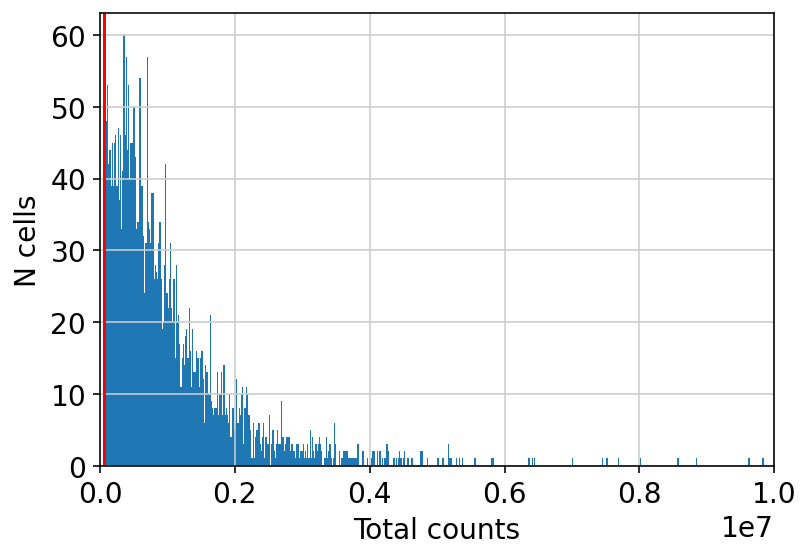

In [53]:
plt.hist(cell_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(50000, color='red')
#plt.xlim(0,1e7) # Try plotting with and without scaling the x-axis. When is this helpful?

## Detected genes 
In addition to ensuring sufficient sequencing depth for each sample, we also want to make sure that the reads are distributed across the transcriptome. Thus, we count the total number of unique genes detected in each sample.

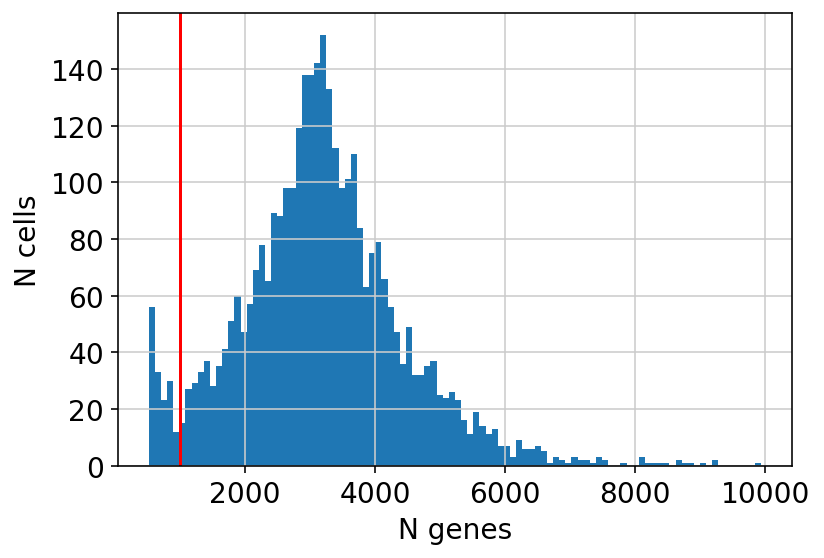

In [54]:
plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(1000, color='red')

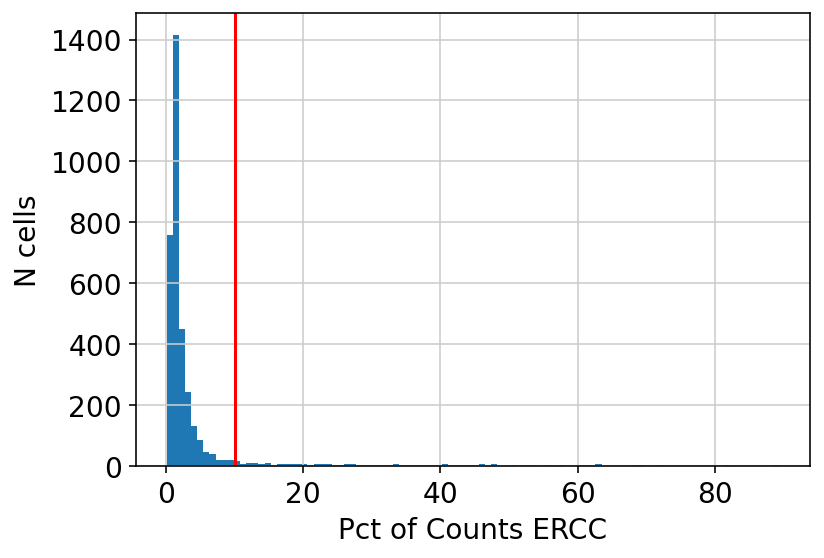

In [60]:
plt.hist(cell_qc_dataframe['pct_counts_ERCC'], bins=100)
plt.xlabel('Pct of Counts ERCC')
plt.ylabel('N cells')
plt.axvline(10, color='red')

## Cell filtering 
Now we can define a cell filter based on our findings:

There isn't an automatic function for removing cells with a high percentage of ERCC reads, but we can use a mask to remove them like so:

In [78]:
low_ERCC_mask = (cell_qc_dataframe['pct_counts_ERCC'] < 10)
adata = adata[low_ERCC_mask]

In [79]:
print(adata)
sc.pp.filter_cells(adata, min_genes=750)
print(adata)
#help(sc.pp.filter_cells)

View of AnnData object with n_obs × n_vars = 3218 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'
filtered out 8 cells that have less than 750 genes expressed


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 3210 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'


## Quality control for genes 
It is typically a good idea to remove genes whose expression level is considered "undetectable". We define a gene as detectable if at least two cells contain more than 5 reads from the gene. However, the threshold strongly depends on the sequencing depth. It is important to keep in mind that genes must be filtered after cell filtering since some genes may only be detected in poor quality cells.

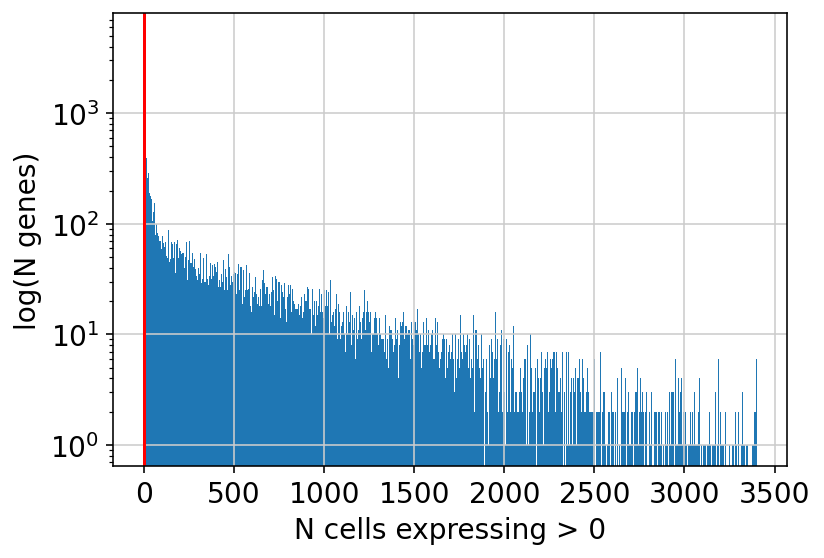

In [80]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') # for visual clarity
plt.axvline(2, color='red')
plt.yscale('log') 

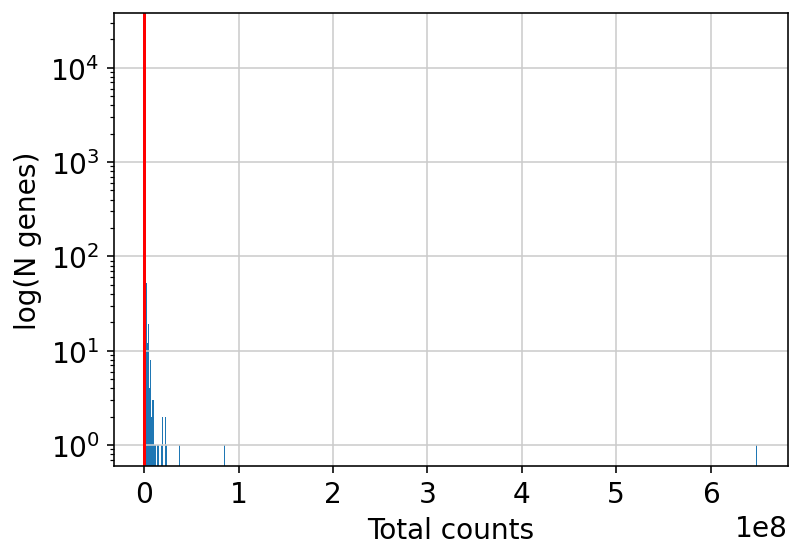

In [81]:
plt.hist(gene_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('log(N genes)') # for visual clarity
plt.yscale('log') 
plt.axvline(10, color='red')

In [84]:
# help(sc.pp.filter_genes)
sc.pp.filter_genes(adata, min_cells=2)
sc.pp.filter_genes(adata, min_counts=10)

filtered out 4075 genes that are detected in less than 2 cells
filtered out 773 genes that are detected in less than 10 counts


In [86]:
# print(adata) ## Final dimensions of the QC'd dataset
adata.write(path + 'brain_qc.h5ad')


## Principle components analysis 
Dimensionality reduction methods seek to take a large set of variables and return a smaller set of components that still contain most of the information in the original dataset.

One of the simplest forms of dimensionality reduction is PCA. Principal component analysis (PCA) is a mathematical procedure that transforms a number of possibly correlated (e.g., expression of genes in a network) variables into a (smaller) number of uncorrelated variables called principal components ("PCs").

Mathematically, the PCs correspond to the eigenvectors of the covariance matrix. The eigenvectors are sorted by eigenvalue so that the first principal component accounts for as much of the variability in the data as possible, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components (the figure below is taken from here).

Biologically, this type of dimensionality reduction is useful and appropriate because cells respond to their environment by turning on regulatory programs that result in expression of modules of genes. As a result, gene expression displays structured co-expression, and dimnesionality reduction by principle component analysis groups those co-varying genes into principle components, ordered by how much variation they explain.

computing PCA
    with n_comps=50
    finished (0:00:09)


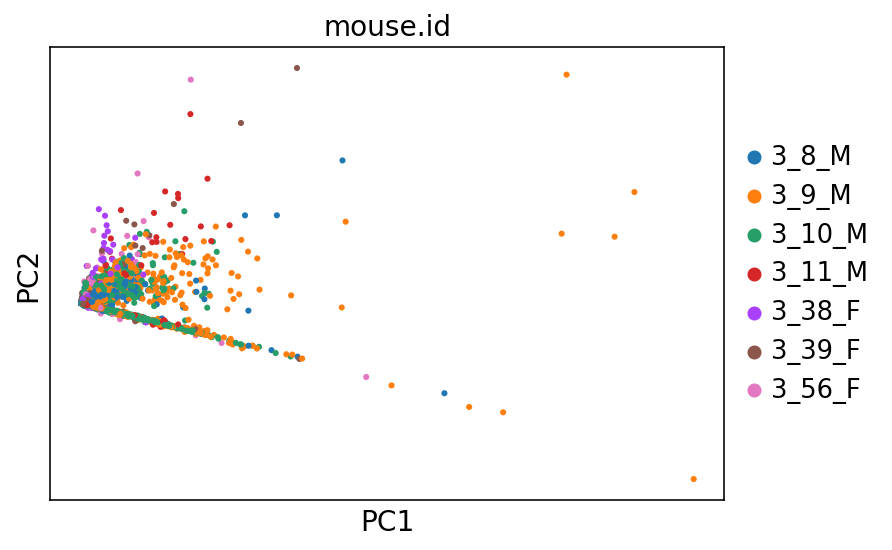

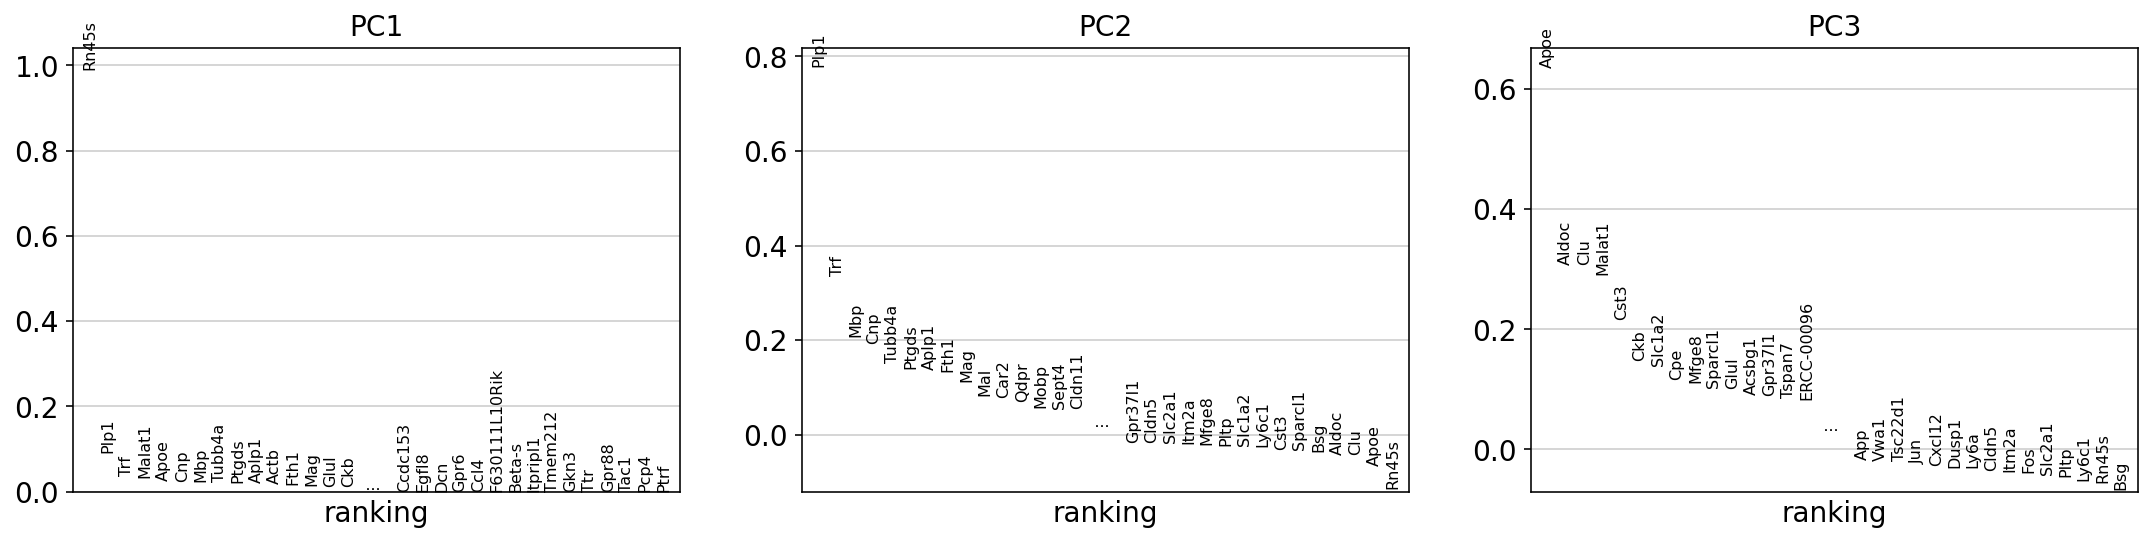

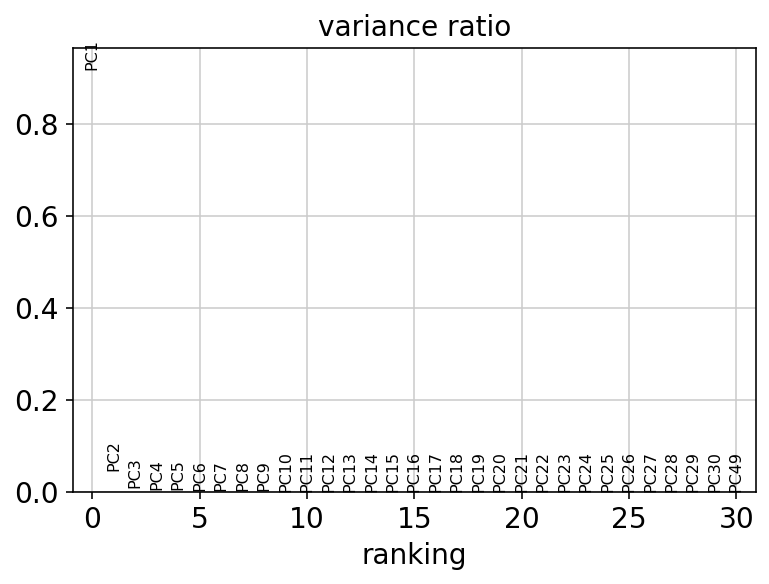

In [99]:
adata = sc.read(path + 'brain_qc.h5ad')
sc.pp.pca(adata)
sc.pl.pca_overview(adata, color='mouse.id')

Highly linear relation in first PC captures most of the variation, which suggests outliers.  

Second row of plots show how much each gene contributes to the PC.  The first PC is determined by a small set of genes, with one composing the vast majority.

The bottom plot shows that PC1 captures the vast majority of the variance in the dataset.

## Normalizing cell library size

Variation in RNA-Seq can be due to libary size caused by natural differences in cell size, variation of RNA capture, variation in the efficiency of PCR amplification, and cell representation from multiplexing.  Much of variation in size due to technical factors, so cells should be normalized to have comparable RNA content.

### CPM

The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. This method assumes that each cell originally contained the same amount of RNA.

In [100]:
adata_cpm = adata.copy() # apply this to a copy so we can compare methods
adata_cpm.raw = adata_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_cpm, 
                         counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


computing PCA
    with n_comps=50
    finished (0:00:11)


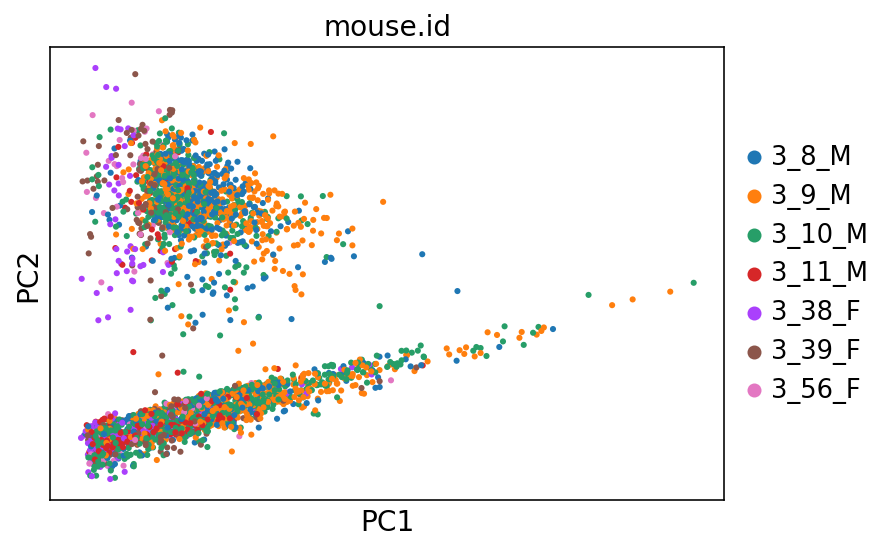

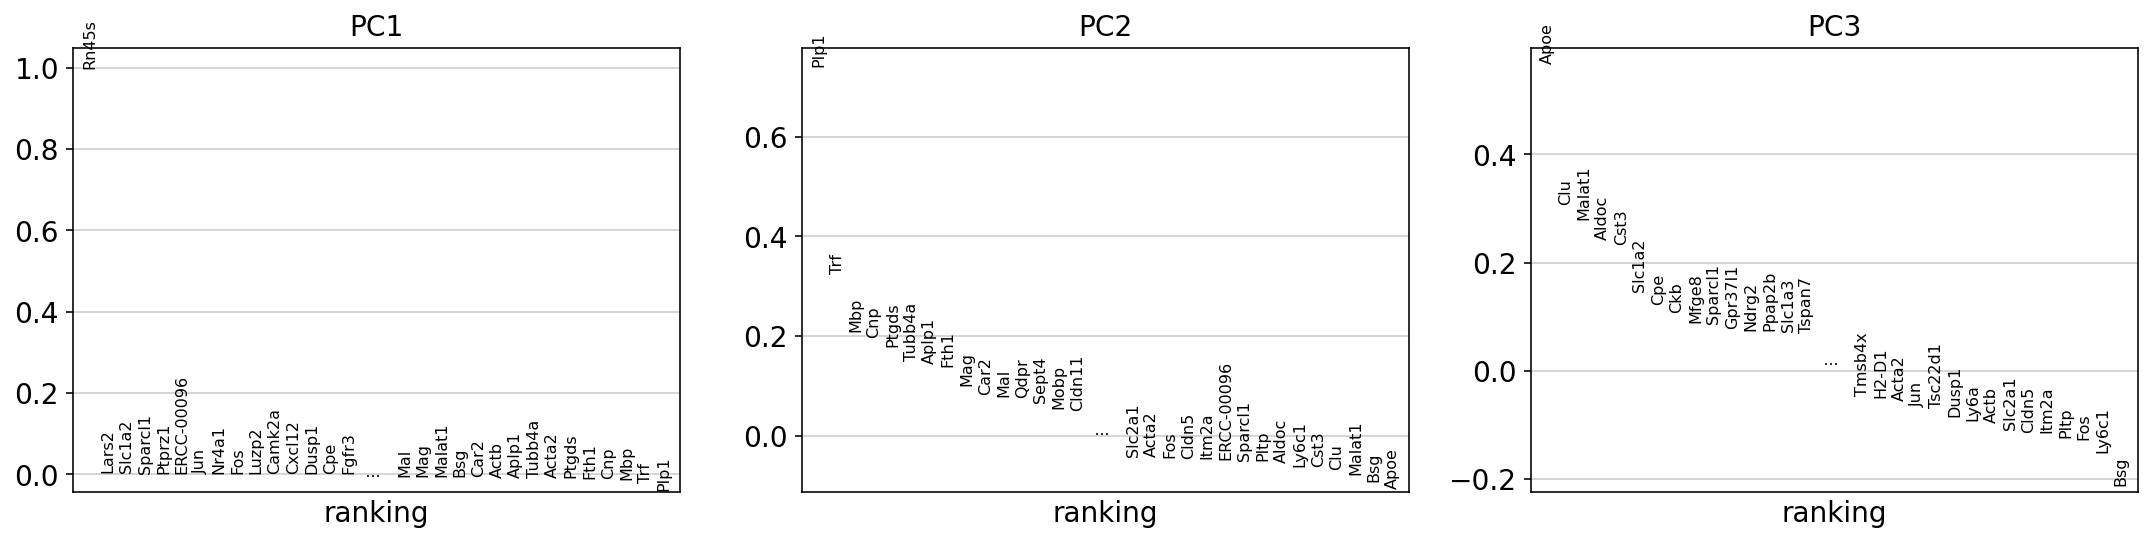

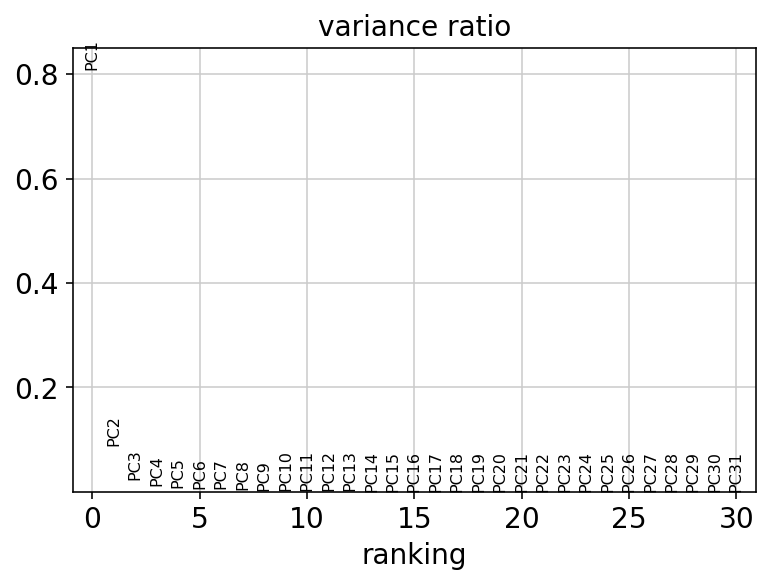

In [101]:
sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='mouse.id')

A potential drawback of CPM is if your sample contains genes that are both very highly expressed and differentially expressed across the cells. In this case, the total molecules in the cell may depend of whether such genes are on/off in the cell and normalizing by total molecules may hide the differential expression of those genes and/or falsely create differential expression for the remaining genes. One way to mitigate this is to exclude highly expressed genes from the size factor estimation.

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Acta2', 'Actb', 'Aldoc', 'Apoe', 'Clu', 'Cpe', 'Cst3', 'Fos', 'Fth1', 'Malat1', 'Mbp', 'Plp1', 'Ptgds', 'Rn45s', 'Trf', 'Ttr']
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:07)


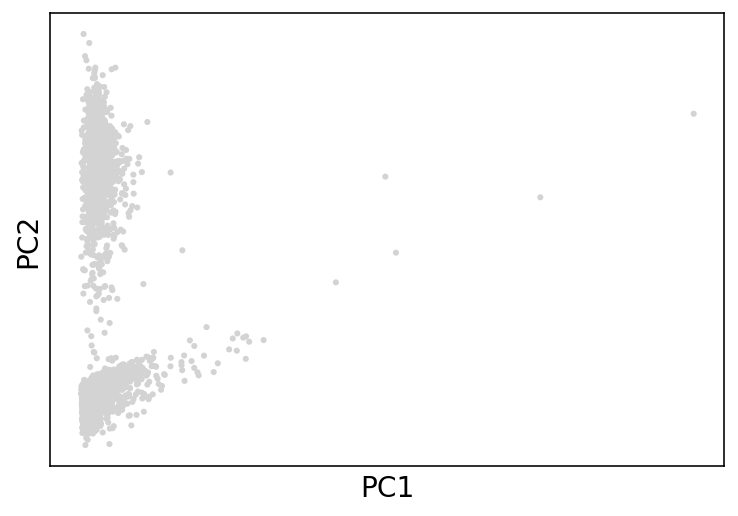

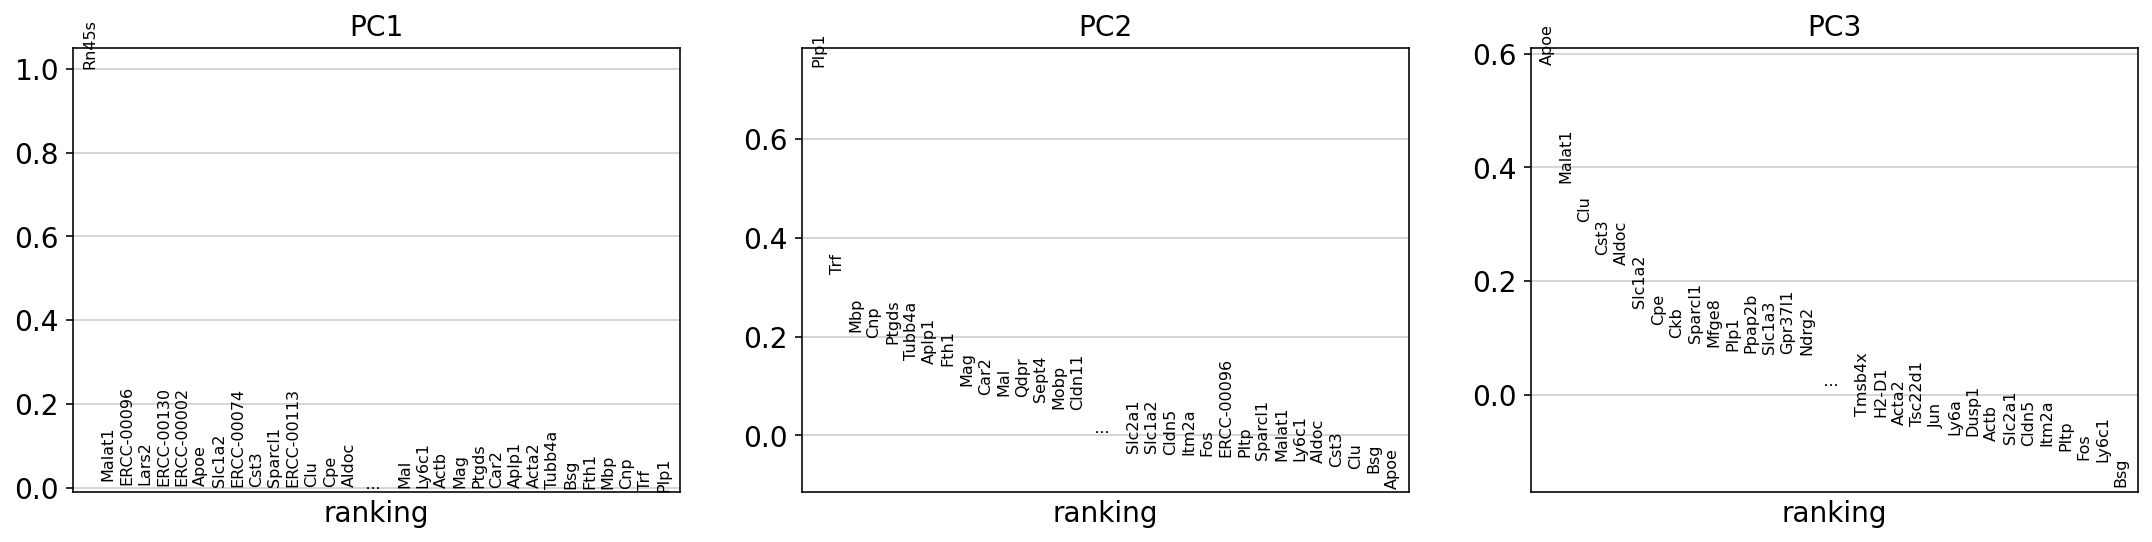

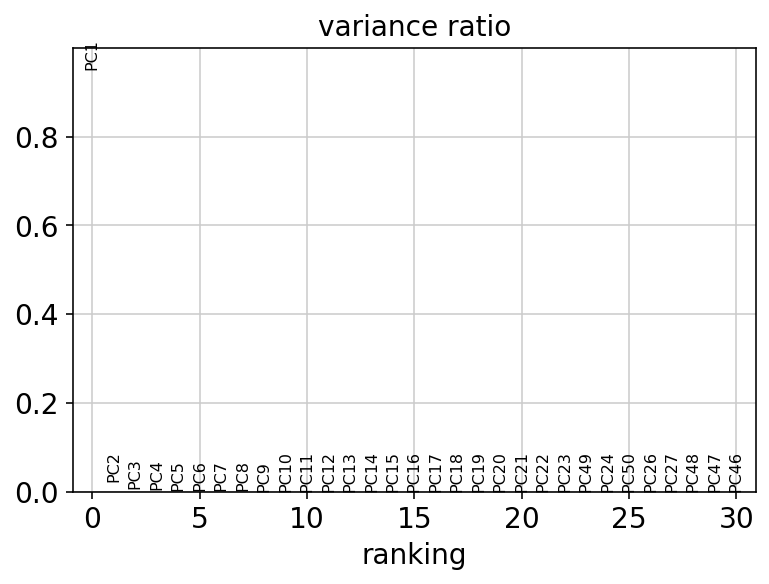

In [102]:
#help(sc.pp.normalize_total)
adata_cpm_ex = adata.copy() # make a copy so we can compare results
sc.pp.normalize_total(adata_cpm_ex, target_sum=1e6, exclude_highly_expressed=True) # normalize
sc.pp.pca(adata_cpm_ex) # run pca
sc.pl.pca_overview(adata_cpm_ex) # plot pca

## Normalizing gene expression 
The dataset is dominated by one or more highly expressed genes. One thing to test is to determine if the offending gene, Rn45s, when removed, yields a more reasonable analysis. This can be assessed by removing the gene and re-running PCA.

computing PCA
    with n_comps=50
    finished (0:00:12)


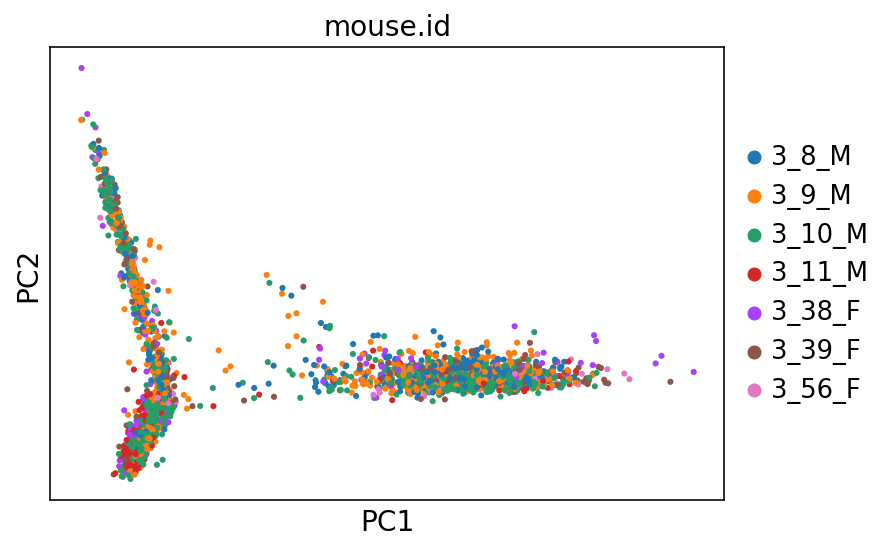

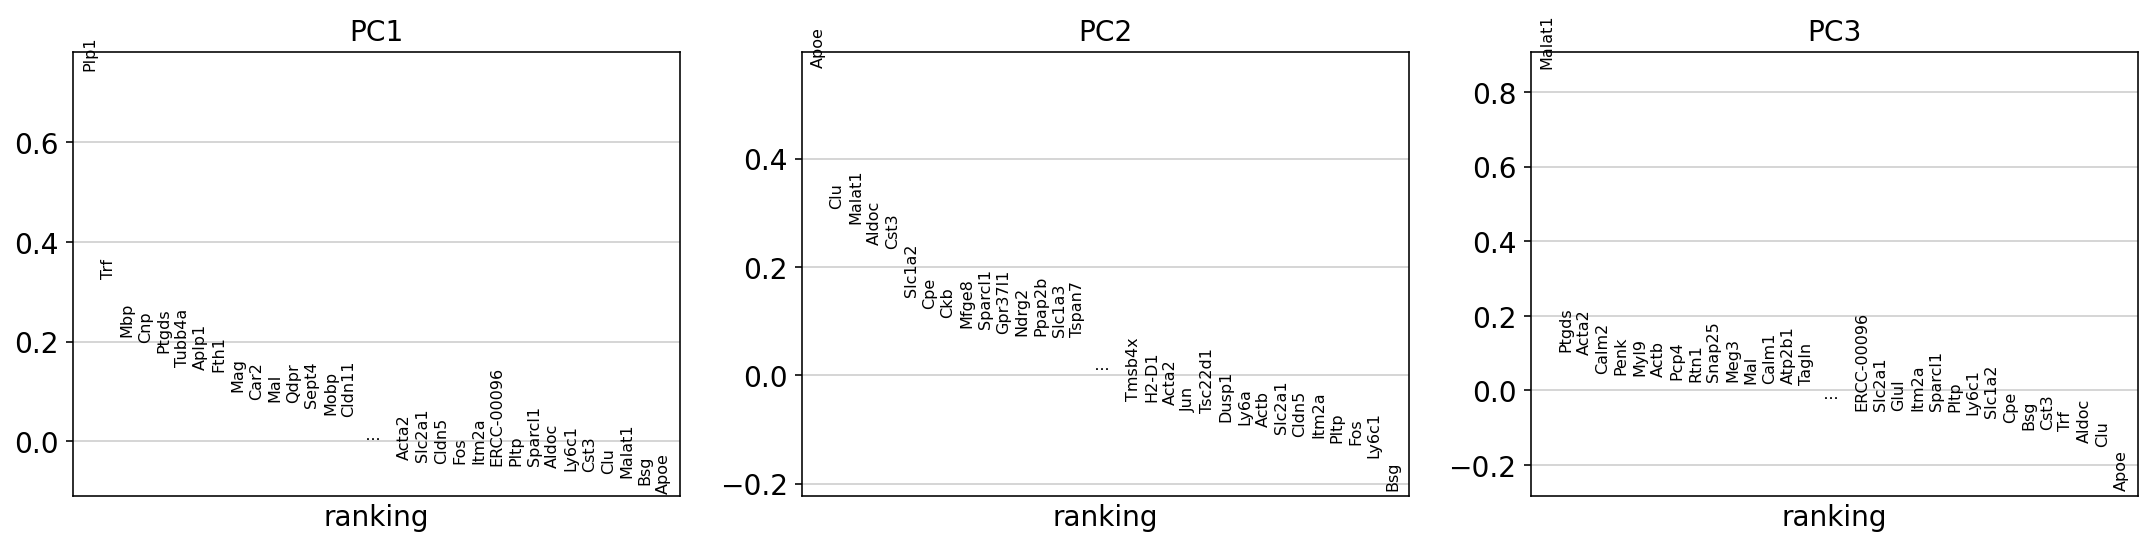

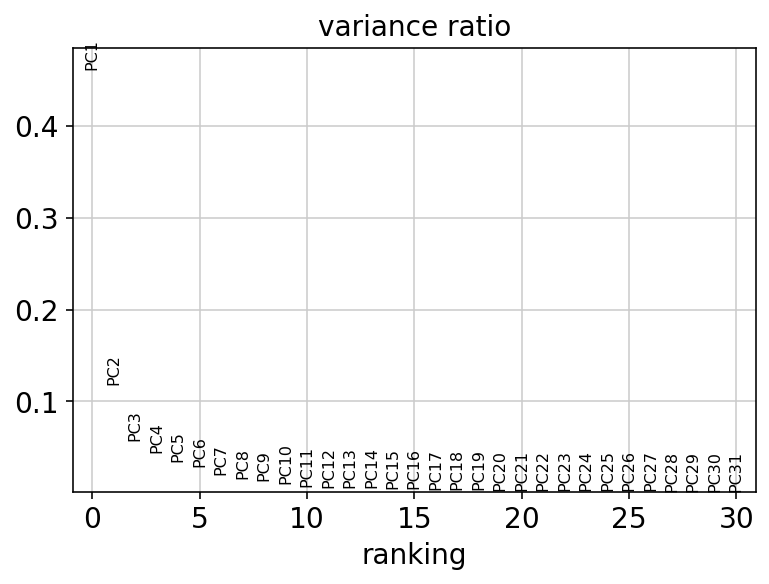

In [103]:
not_Rn45s = adata_cpm.var.index != 'Rn45s'
adata_no_Rn45s = adata_cpm[:, not_Rn45s]

sc.pp.pca(adata_no_Rn45s)
sc.pl.pca_overview(adata_no_Rn45s, color='mouse.id')

computing PCA
    with n_comps=50
    finished (0:00:13)


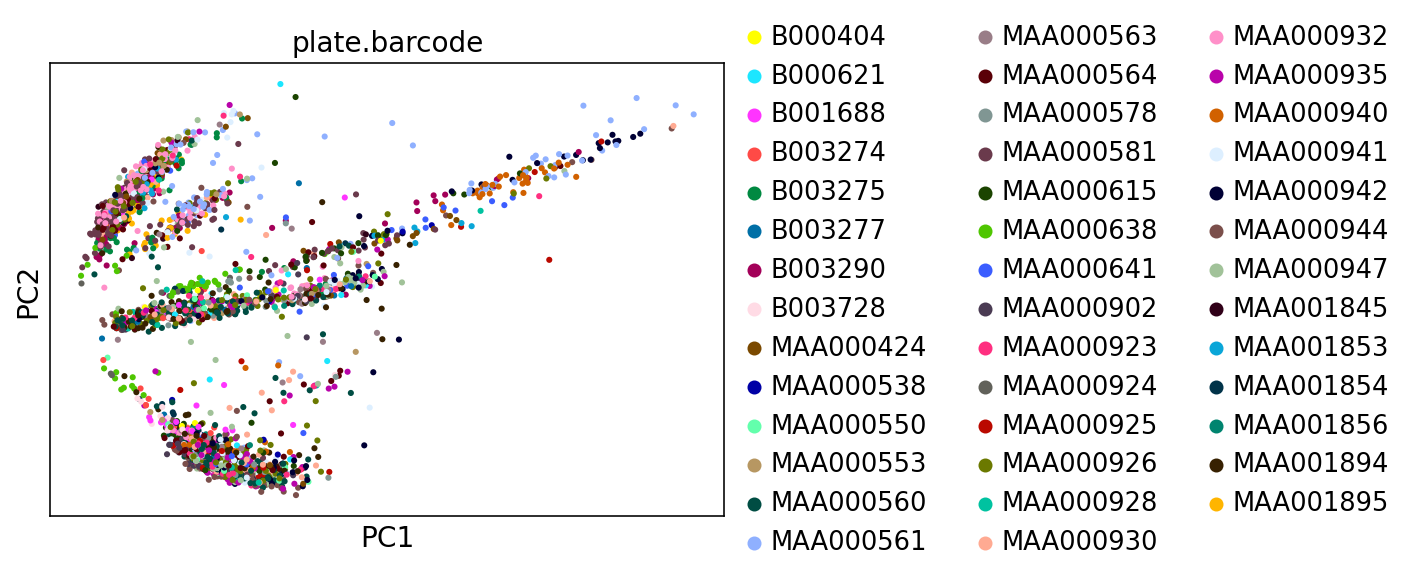

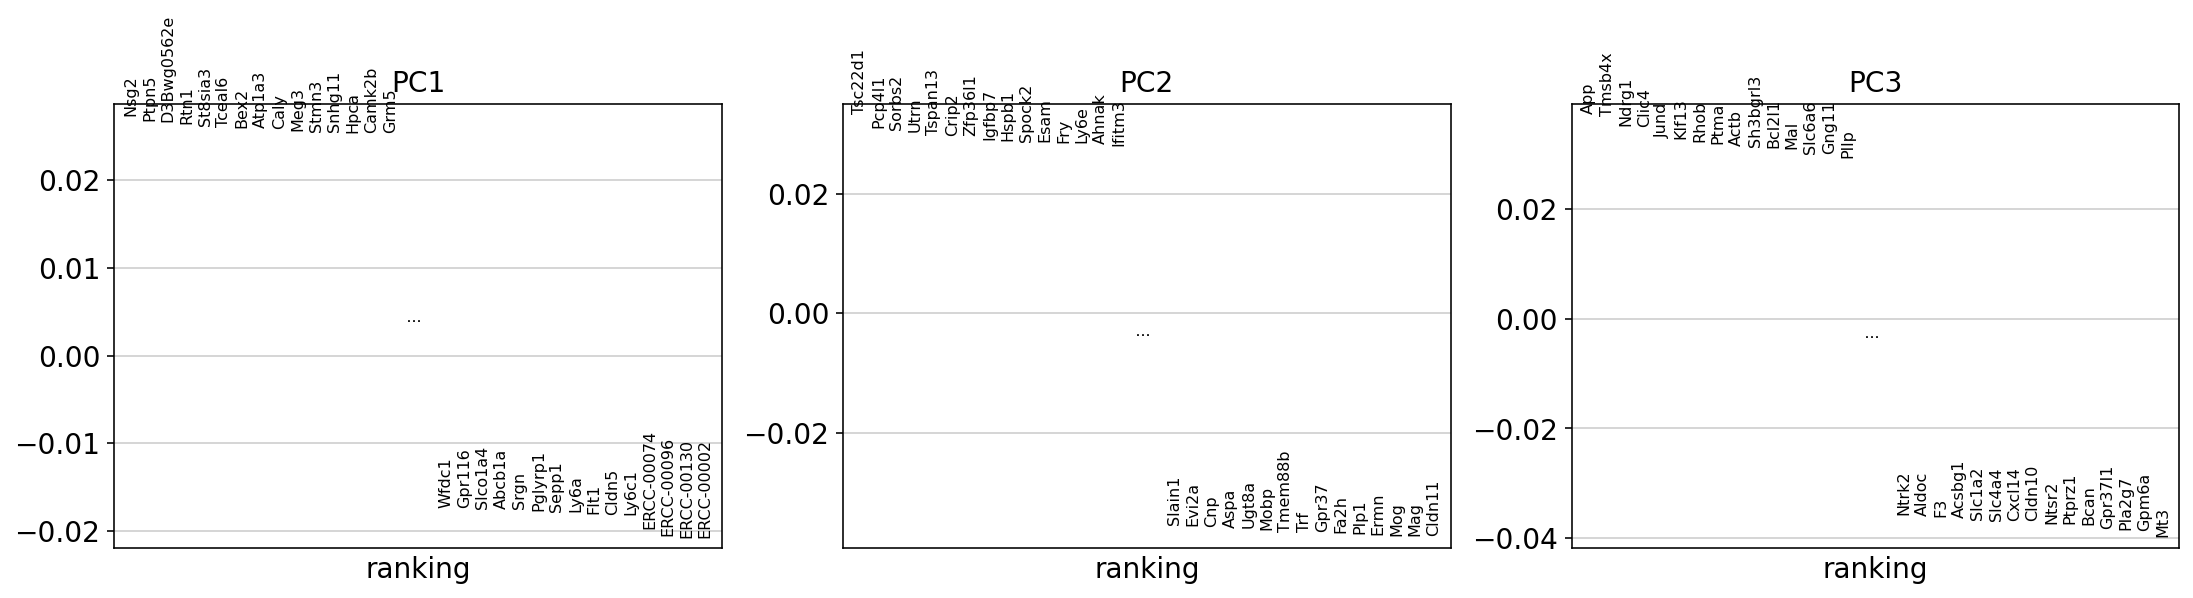

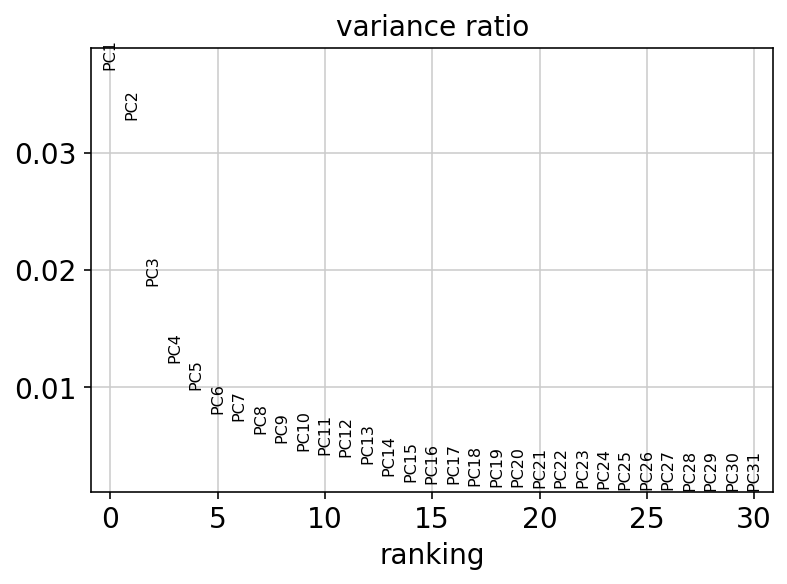

In [104]:
sc.pp.log1p(adata_cpm)
sc.pp.scale(adata_cpm)

sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='plate.barcode')

In [105]:
adata_cpm.write(path + 'brain_normalized.h5ad')

## Dimensionality reduction

Dimensionality reduction methods seek to take a large set of variables and return a smaller set of components that still contain most of the information in the original dataset. This implies an inherent tradeoff between information loss and improved interpretability: all dimensionality reduction methods discard some information, but they also play an important role in helping us make sense of a giant matrix of values.

We already saw one example of dimensionality reduction in PCA. Let's look at two other common approaches to dimensionality reduction: tSNE and UMAP.

In [107]:
adata = sc.read(path + 'brain_normalized.h5ad')

## tSNE 

An alternative to PCA for visualizing scRNASeq data is a tSNE plot. tSNE (t-Distributed Stochastic Neighbor Embedding) combines dimensionality reduction (e.g. PCA) with random walks on the nearest-neighbour network to map high dimensional data (i.e. our 18,585 dimensional expression matrix) to a 2-dimensional space. In contrast with PCA, tSNE can capture nonlinear structure in the data, and tries to preserve the local distances between cells. Due to the non-linear and stochastic nature of the algorithm, tSNE is more difficult to intuitively interpret: while tSNE faithfully represents local relationships, it doesn't always capture the relatioships between more distant cells correctly.

tSNE is a stochastic algorithm which means running the method multiple times on the same dataset will result in different plots. To ensure reproducibility, we fix the "seed" of the random-number generator in the code below so that we always get the same plot.

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:41)


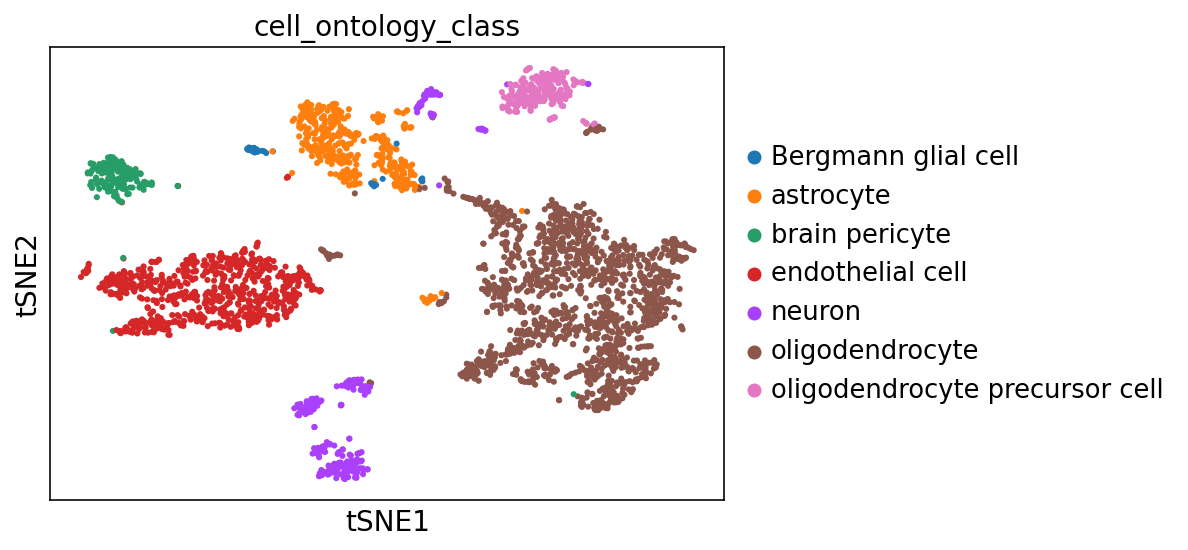

In [108]:
sc.tl.tsne(adata, perplexity=30, learning_rate=1000, random_state=0)

sc.pl.tsne(adata, color='cell_ontology_class')

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:45)


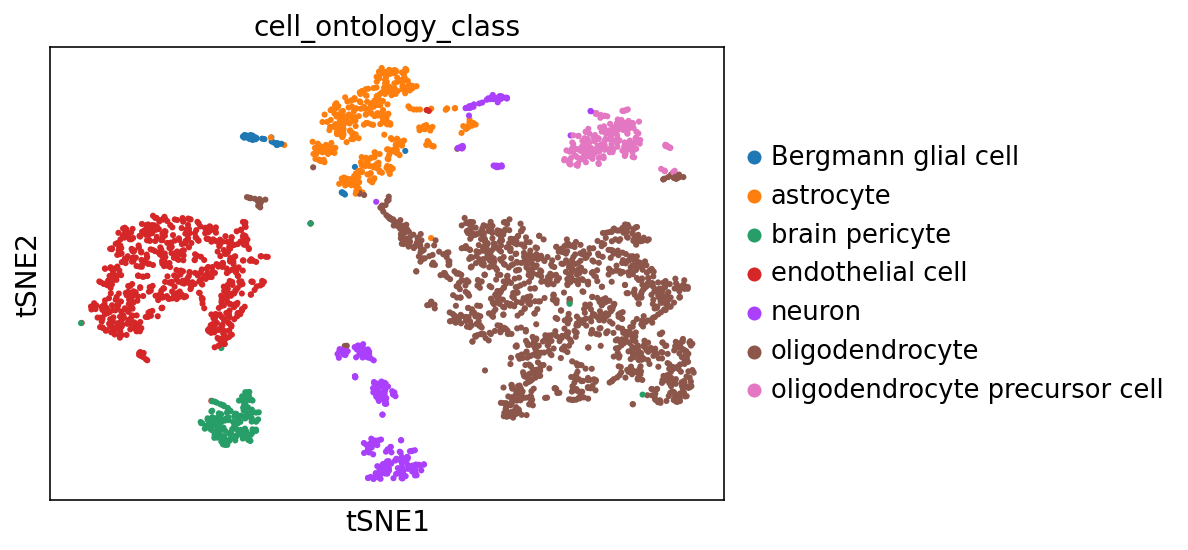

In [110]:
# Trying different values
sc.tl.tsne(adata, perplexity=20, learning_rate=1000, random_state=0)

sc.pl.tsne(adata, color='cell_ontology_class')

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:49)


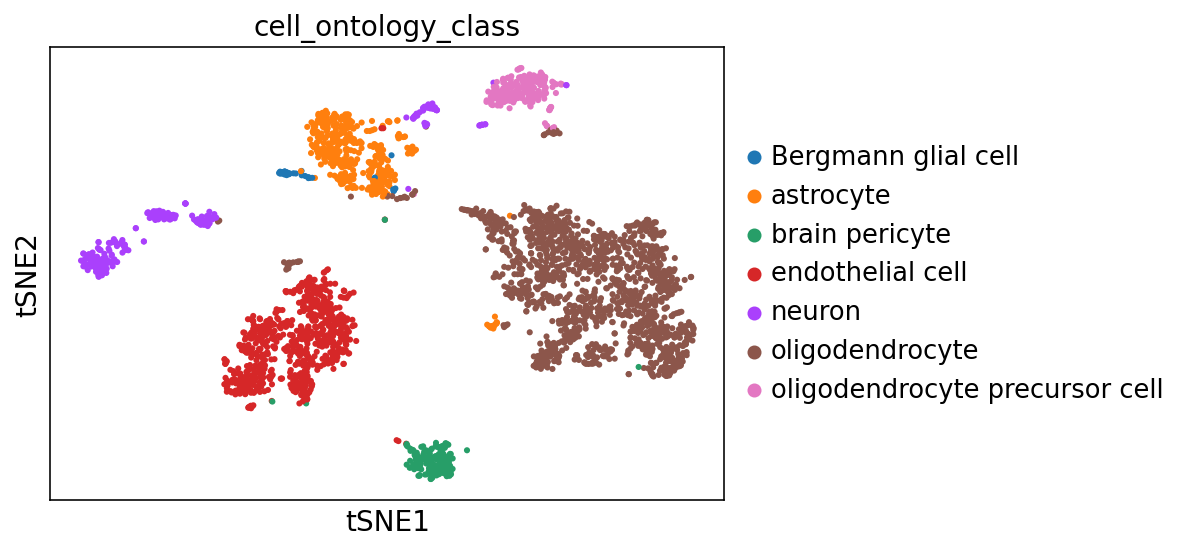

In [111]:
sc.tl.tsne(adata, perplexity=40, learning_rate=1000, random_state=0)

sc.pl.tsne(adata, color='cell_ontology_class')

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:46)


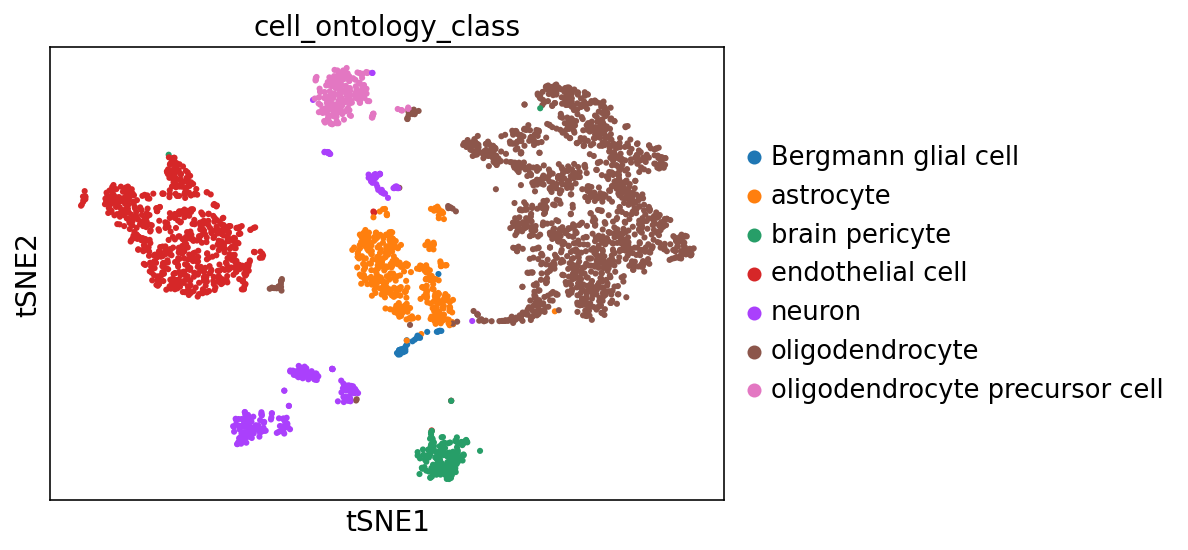

In [112]:
sc.tl.tsne(adata, perplexity=30, learning_rate=500, random_state=0)

sc.pl.tsne(adata, color='cell_ontology_class')

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:42)


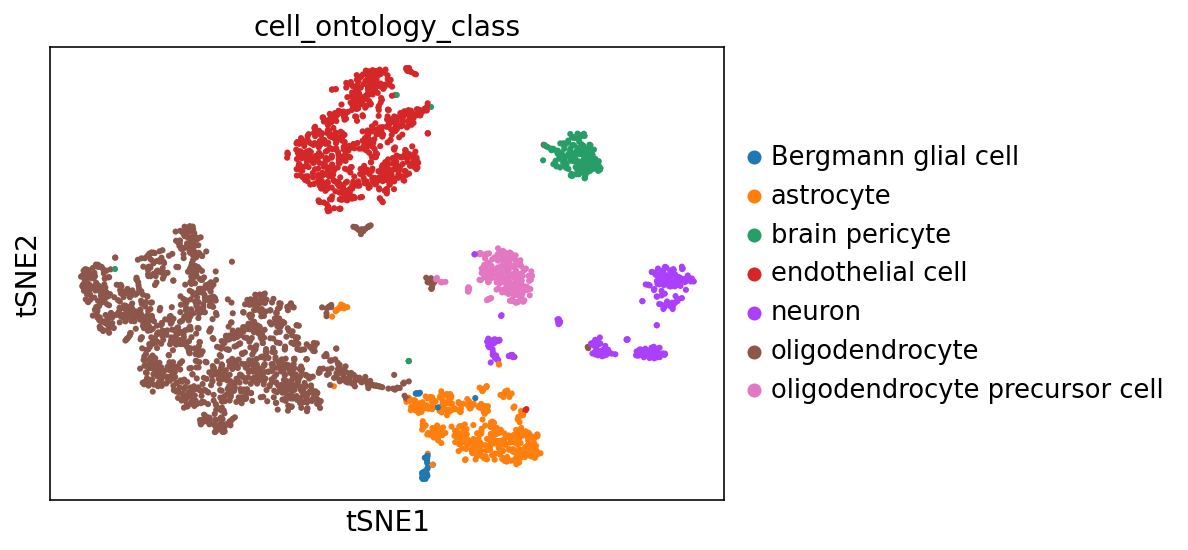

In [113]:
sc.tl.tsne(adata, perplexity=30, learning_rate=2000, random_state=0)

sc.pl.tsne(adata, color='cell_ontology_class')

## UMAP 

UMAP (Uniform Approximation and Projection) is another nonlinear dimensionality reduction method. Like tSNE, UMAP is nondeterministic and requires that we fix the random seed to ensure reproducibility. While tSNE optimizes for local structure, UMAP tries to balance the preservation of local and global structure. For this reason, we prefer UMAP over tSNE for exploratory analysis and general visualization.

UMAP is based upon the neighbor graph, which we'll talk about later in the clustering lesson.

In [114]:
sc.pp.neighbors(adata) # UMAP is based on the neighbor graph; we'll compute this first
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


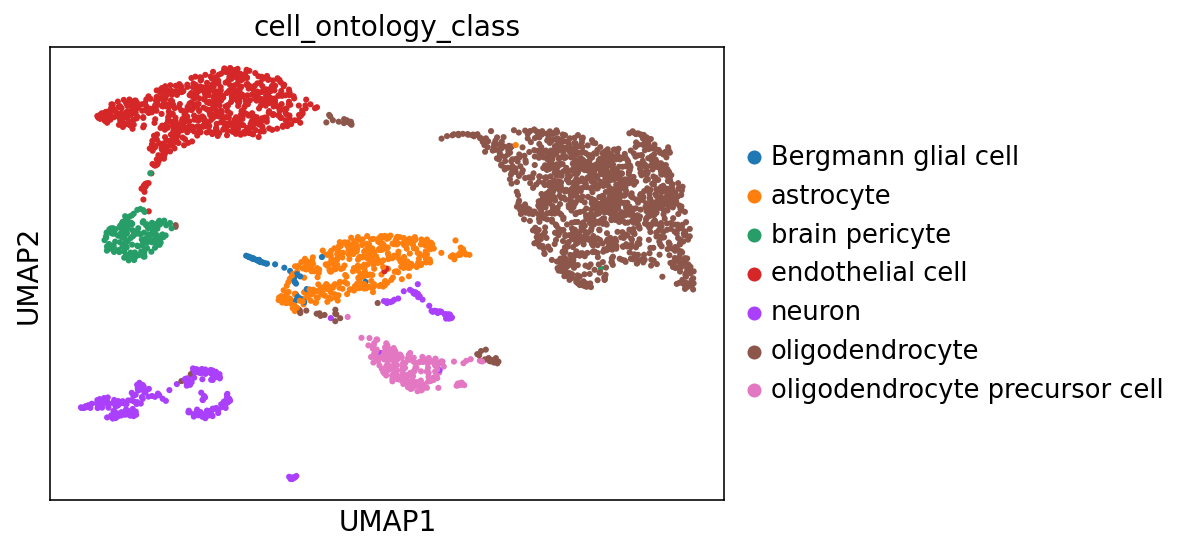

In [115]:
sc.pl.umap(adata, color='cell_ontology_class')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


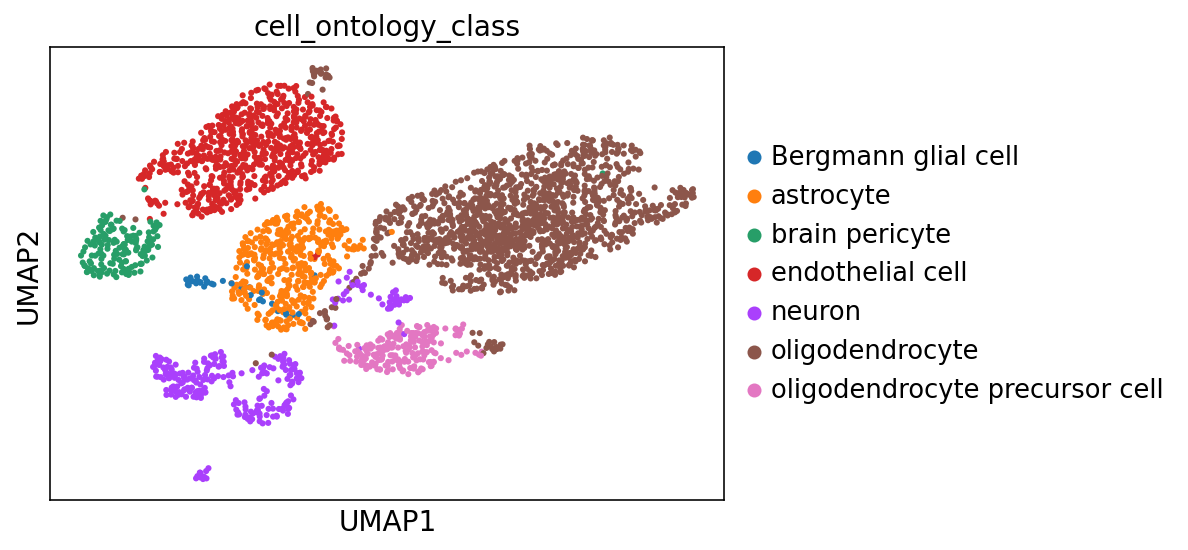

In [118]:
# Trying different parameters
sc.tl.umap(adata, min_dist=1.0, spread=1.0, random_state=0, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

computing UMAP


/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


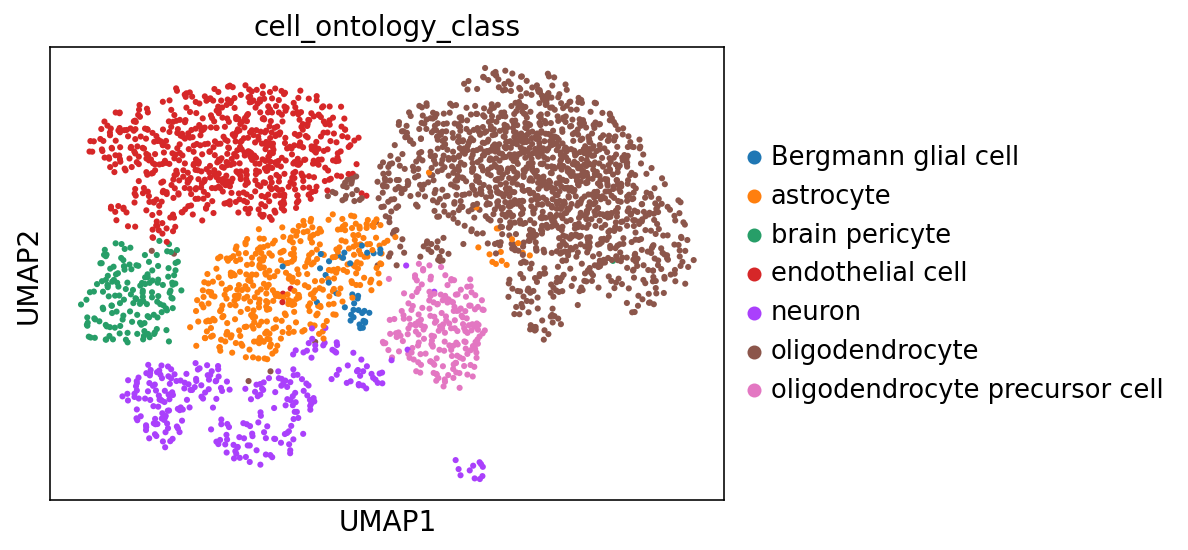

In [119]:
sc.tl.umap(adata, min_dist=2.0, spread=1.0, random_state=0, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


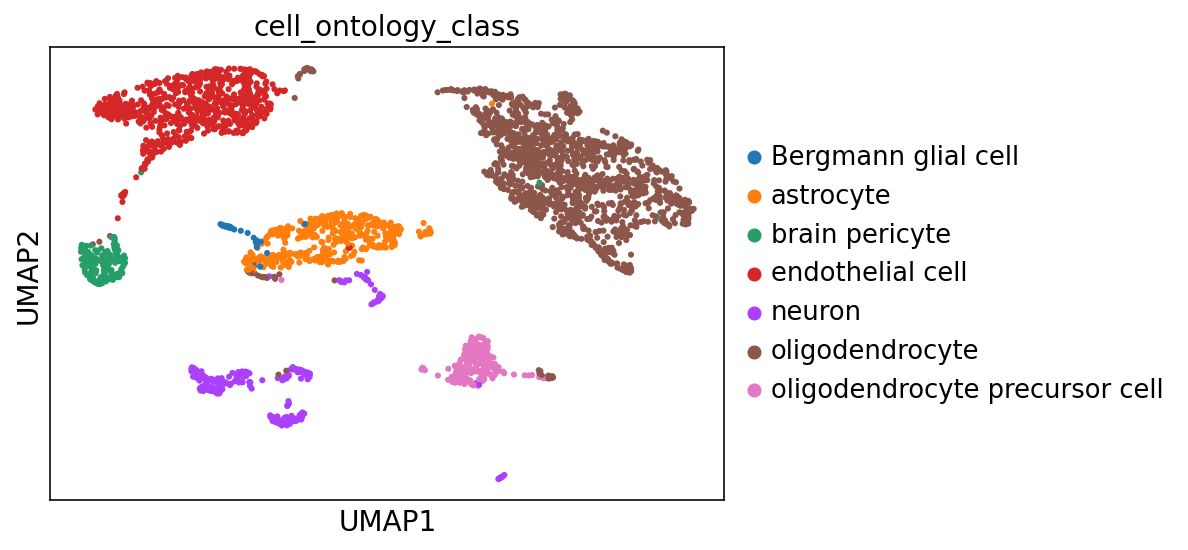

In [120]:
sc.tl.umap(adata, min_dist=0.5, spread=2.0, random_state=0, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

computing UMAP


/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


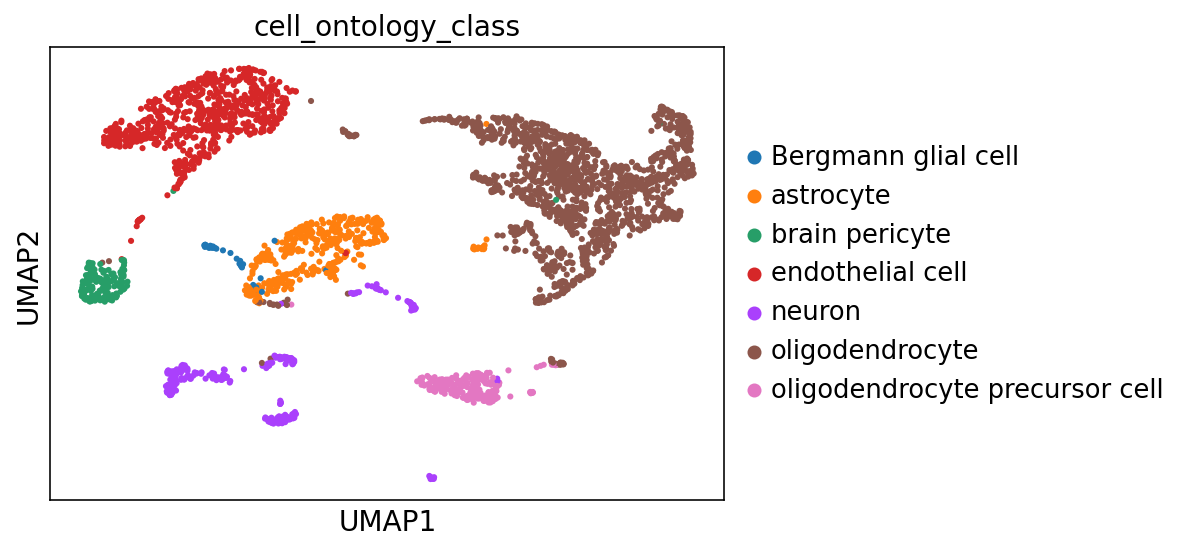

In [121]:
sc.tl.umap(adata, min_dist=0.5, spread=4.0, random_state=0, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


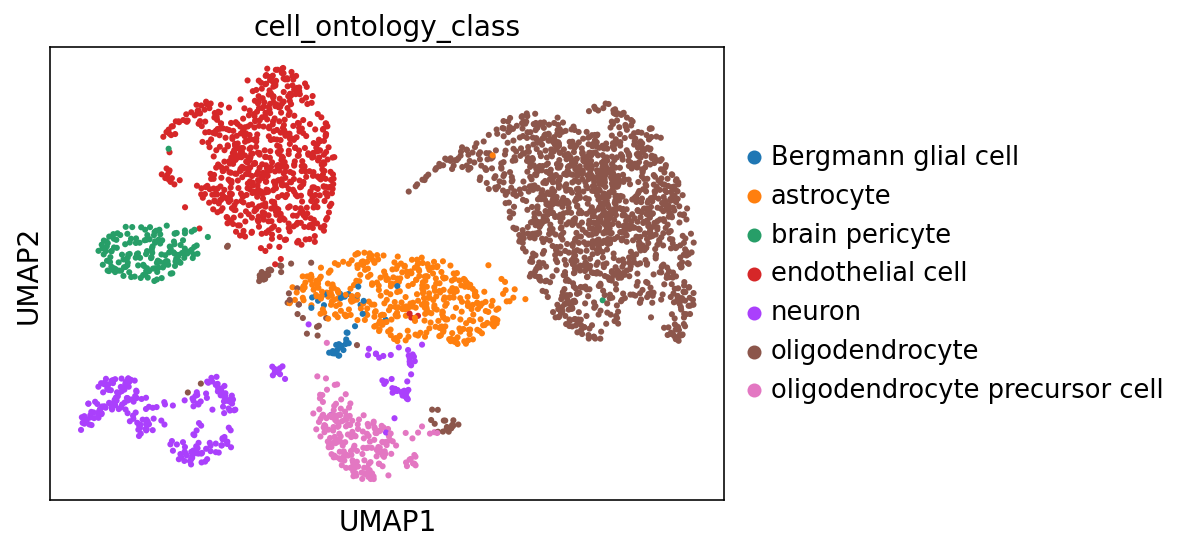

In [122]:
sc.tl.umap(adata, min_dist=0.5, spread=0.5, random_state=0, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

In [123]:
# Checkpoint
adata.write(path + 'brain_embeddings.h5ad')

## Clustering

Grouping cells based on the similarity of their expression profiles allows us to identify cell types and states, as well as infer differences between groups. This is done either via clustering or community detection.

Unsupervised clustering is useful in many different applications and has been widely studied in machine learning. Some of the most popular approaches are hierarchical clustering and k-means clustering. These methods compute a distance metric between cells (often based on a low-dimensional representation, such as PCA, tSNE or UMAP), and then iteratively group cells together based on these distances.

Community detection methods (also referred to as 'graph-based clustering') partition the neighbor graph. The neighbor graph treats each cell as a node, with edges connecting each node to its k nearest neighbors (based on similar distance metrics described above). The graph is then partitioned into modules based on these connectivities. These methods are typically faster than other clustering methods with similar effectiveness.

One thing virtually all clustering or community detection methods have in common is some flavor of a resolution parameter. This parameter controls how fine- or coarse-grained the inferred clusters are. This parameter can have major effects on your results! We'll explore this in more detail below.

Here, we'll explore k-means clustering and the graph-based louvain clustering method.

In [3]:
# Checkpoint 
adata = sc.read(path + 'brain_embeddings.h5ad')

NameError: name 'path' is not defined

### k-means 

In k-means clustering, the goal is to partition N cells into k different clusters. This is done in an iterative manner, cluster centers are assigned and each cell is assigned to its nearest cluster:

Let's try this out on the umap representation of our dataset. Scanpy doesn't include a method for k-means clustering, so we'll extract the umap coordinates that we calculated earlier and use scikit-learn for this task instead.

/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


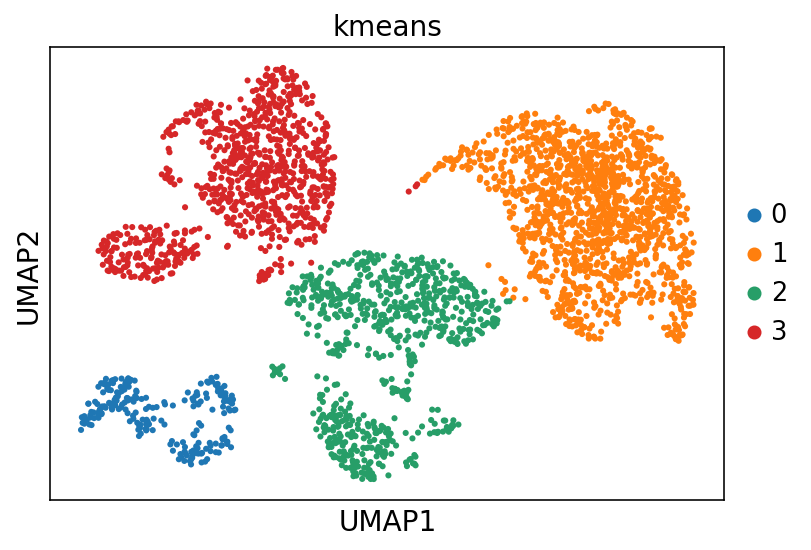

In [125]:

umap_coordinates = adata.obsm['X_umap'] # extract the UMAP coordinates for each cell
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results

### Evaluating clustering 

Intuitively, we can see from the plot that our value of k (the number of clusters) is probably too low.

This dataset has "ground truth" cell type labels available. We can use these to assess our cluster labels a bit more rigorously using the adjusted Rand index. This index is a measure between (0, 1) which indicates the similarity between two sets of categorical labels (e.g., our cell type labels and cluster labels). A value of 1 means the two clusterings are identical, and 0 means the level of similarity expected by random chance.

In [126]:
rand_index = adjusted_rand_score(labels_true = adata.obs['cell_ontology_class'], labels_pred = adata.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.81


/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


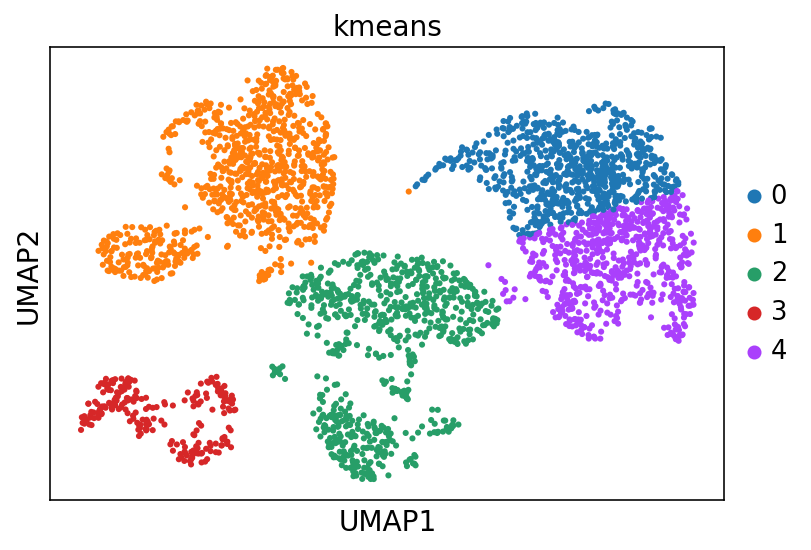

The Rand index is 0.55


In [129]:
kmeans = KMeans(n_clusters= 5, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results
rand_index = adjusted_rand_score(labels_true = adata.obs['cell_ontology_class'], labels_pred = adata.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


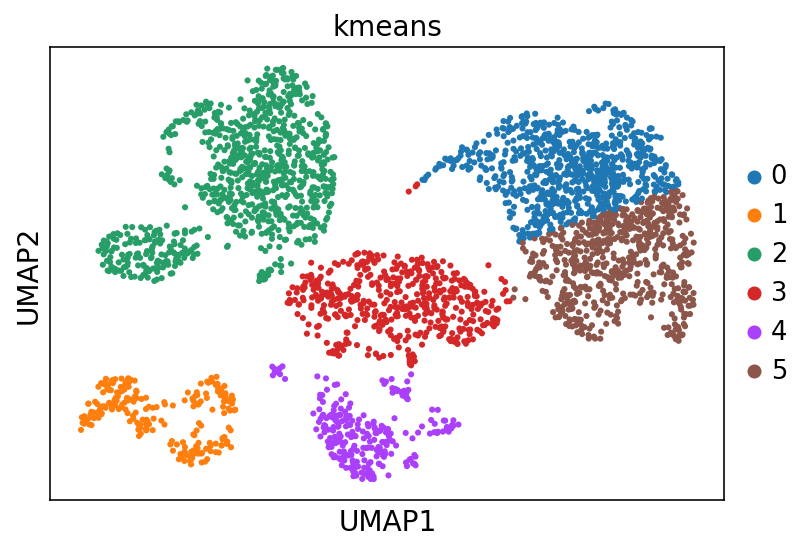

The Rand index is 0.61


In [130]:
kmeans = KMeans(n_clusters= 6, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results
rand_index = adjusted_rand_score(labels_true = adata.obs['cell_ontology_class'], labels_pred = adata.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


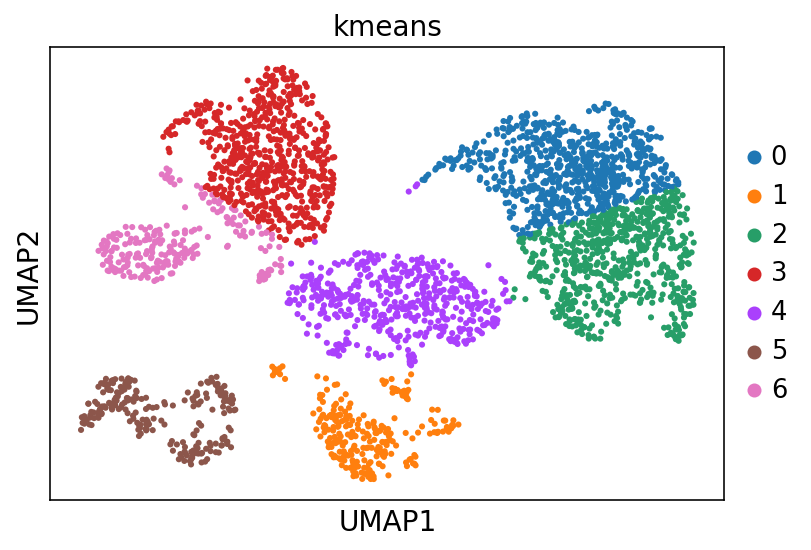

The Rand index is 0.63


In [131]:
kmeans = KMeans(n_clusters= 7, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results
rand_index = adjusted_rand_score(labels_true = adata.obs['cell_ontology_class'], labels_pred = adata.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

### Graph-based methods 

Graph-based methods attempt to partition a pre-computed neighhbor graph into modules (i.e., groups / clusters of cells) based on their connectivity. Currently, the most widely used graph-based methods for single cell data are variants of the louvain algorithm. The intuition behind the louvain algorithm is that it looks for areas of the neighbor graph that are more densely connected than expected (based on the overall connectivity in the graph).

In [134]:
# Louvain buggy

adata_louv = adata.copy()
sc.tl.louvain(adata_louv, resolution=1.0, random_state=0)
sc.pl.umap(adata, color='louvain') # plot the results
rand_index = adjusted_rand_score(adata.obs['cell_ontology_class'], adata.obs['louvain'])
print('The Rand index is', round(rand_index, 2))

running Louvain clustering


AttributeError: module 'louvain' has no attribute '__version__'

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


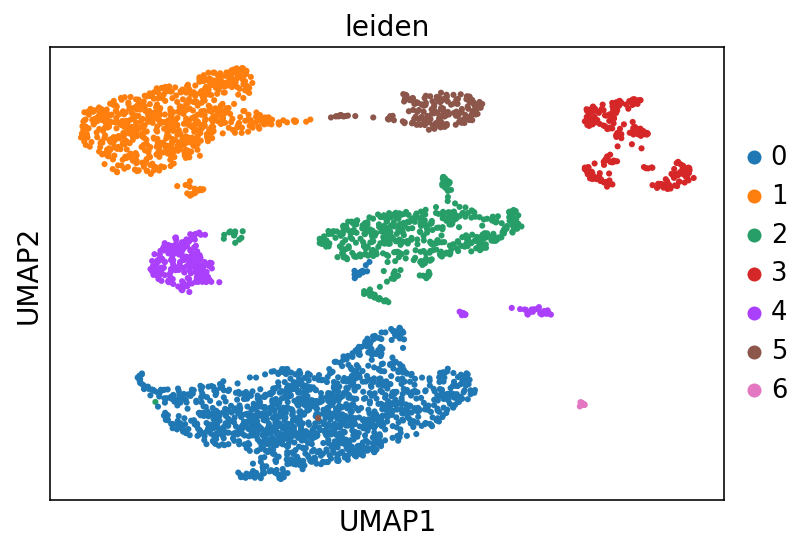

The Rand index is 0.9


In [147]:
# Leiden

adata_leid = adata.copy()
sc.tl.leiden(adata_leid, resolution=0.1, random_state=0)
sc.pl.umap(adata_leid, color='leiden') # plot the results
rand_index = adjusted_rand_score(adata_leid.obs['cell_ontology_class'], adata_leid.obs['leiden'])
print('The Rand index is', round(rand_index, 2))

In [137]:
help(sc.pp.neighbors)
help(sc.tl.umap)

Help on function neighbors in module scanpy.neighbors:

neighbors(adata: anndata._core.anndata.AnnData, n_neighbors: int = 15, n_pcs: Optional[int] = None, use_rep: Optional[str] = None, knn: bool = True, random_state: Union[NoneType, int, numpy.random.mtrand.RandomState] = 0, method: Optional[Literal['umap', 'gauss', 'rapids']] = 'umap', metric: Union[Literal['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan'], Literal['braycurtis', 'canberra', 'chebyshev', 'correlation', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'], Callable[[numpy.ndarray, numpy.ndarray], float]] = 'euclidean', metric_kwds: Mapping[str, Any] = mappingproxy({}), key_added: Optional[str] = None, copy: bool = False) -> Optional[anndata._core.anndata.AnnData]
    Compute a neighborhood graph of observations [McInnes18]_.
    
    The neighbor search efficiency of this heavily relies on 

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


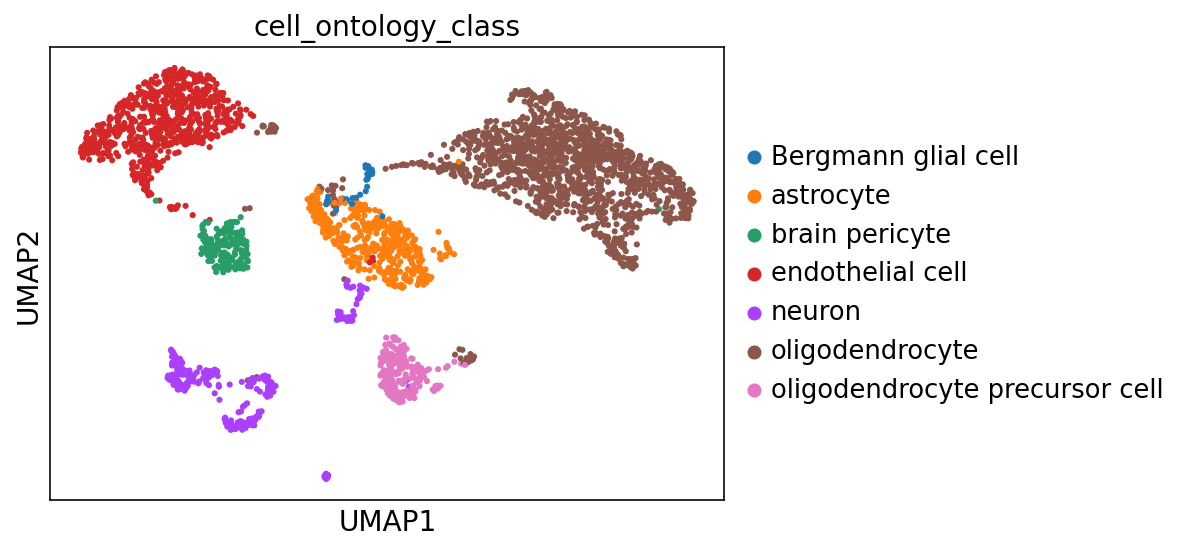

/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


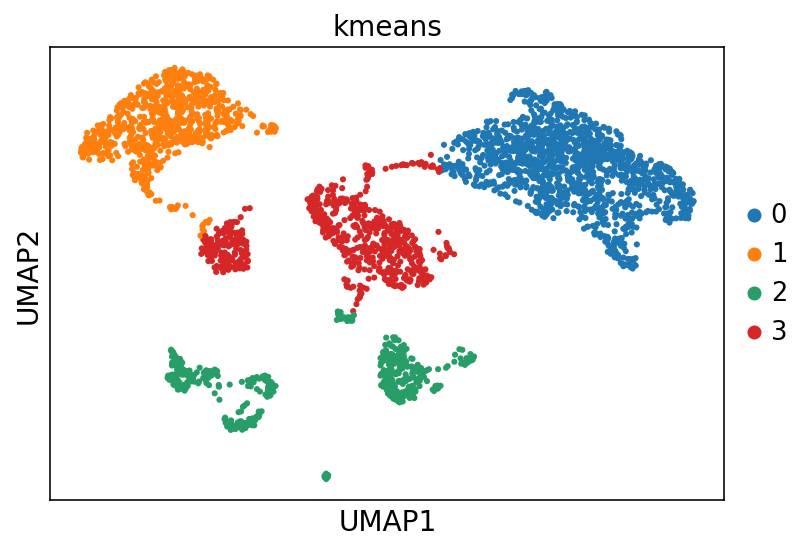

In [138]:
# Recalculating neighbors, UMAP, and clustering
# Experiment 1
sc.pp.neighbors(adata, n_neighbors=20) # Adjusting n_neighbors parameter
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=0, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

umap_coordinates = adata.obsm['X_umap'] 
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


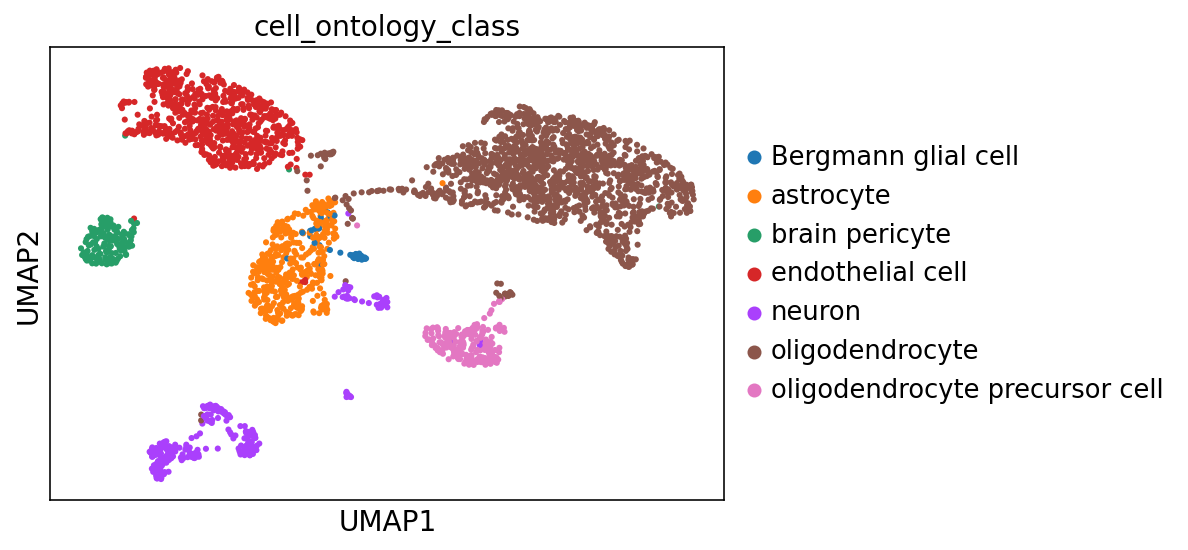

/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


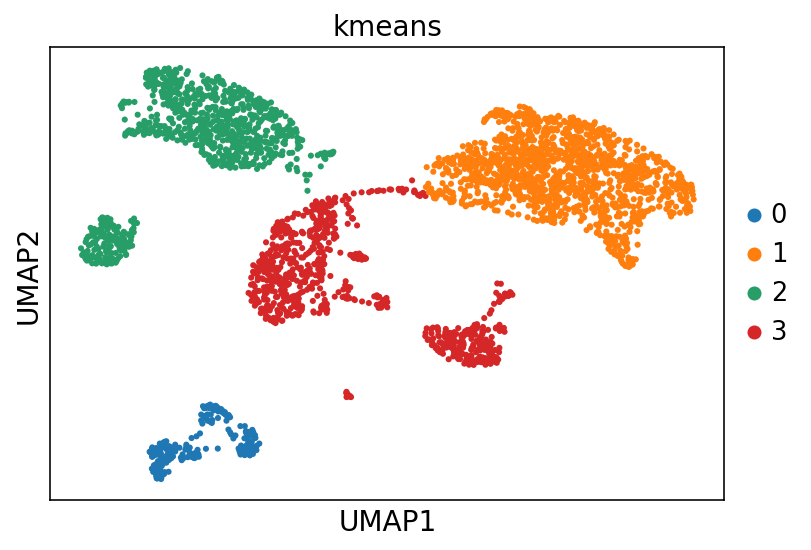

In [139]:
# Experiment 2
sc.pp.neighbors(adata, n_neighbors=25) # Adjusting n_neighbors parameter
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=0, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

umap_coordinates = adata.obsm['X_umap'] 
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


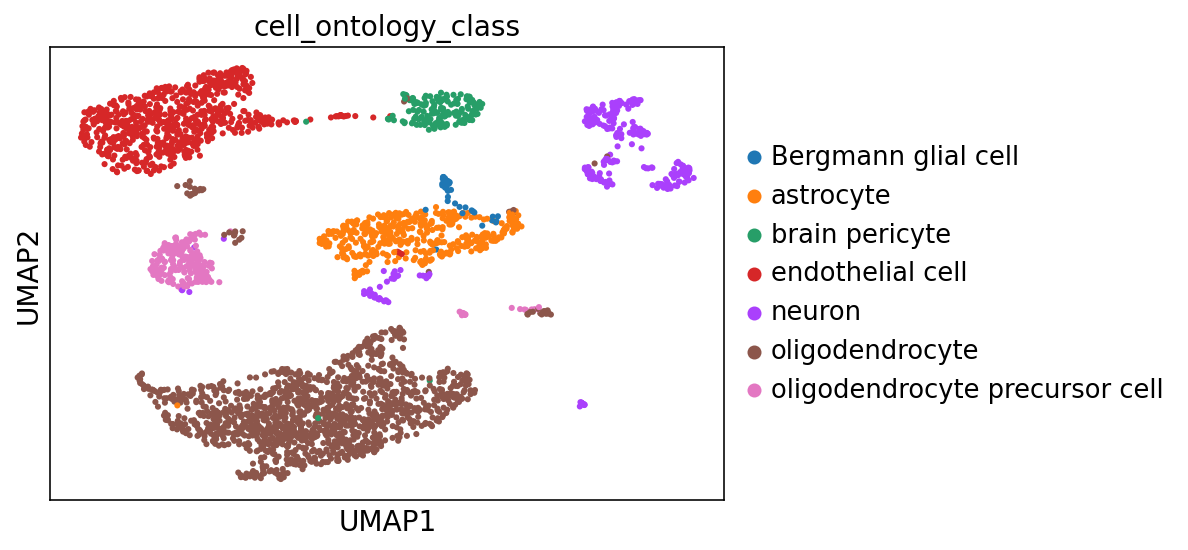

/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


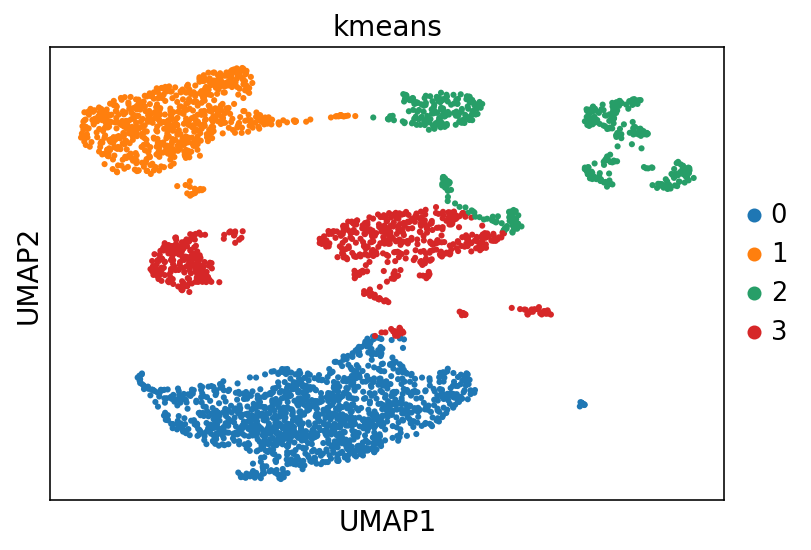

In [140]:
# Experiment 3
sc.pp.neighbors(adata, n_neighbors=10) # Adjusting n_neighbors parameter
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=0, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

umap_coordinates = adata.obsm['X_umap'] 
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


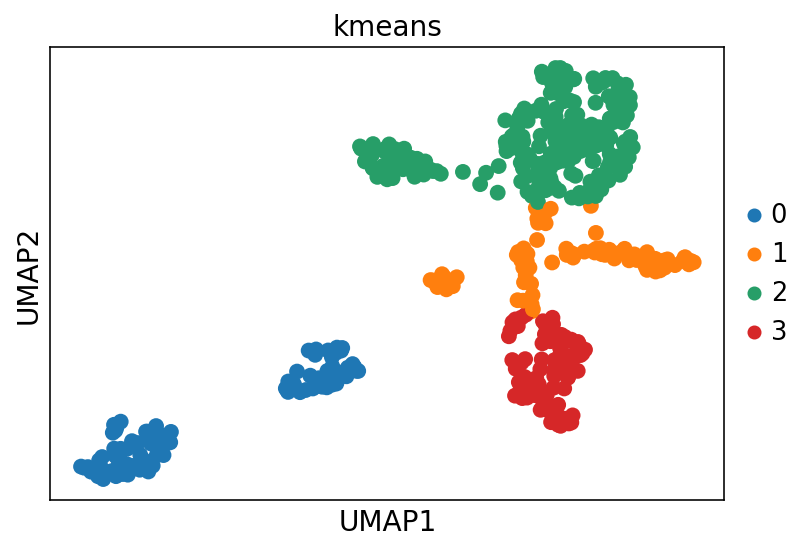

In [142]:
cerebellum = adata[adata.obs['subtissue'] == 'Cerebellum']
sc.pp.neighbors(cerebellum)
sc.tl.umap(cerebellum)

umap_coordinates = cerebellum.obsm['X_umap'] 
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

cerebellum.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
cerebellum.obs['kmeans'] = cerebellum.obs['kmeans'].astype(str)

sc.pl.umap(cerebellum, color='kmeans') # plot the results

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


/home/vince/Bio/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


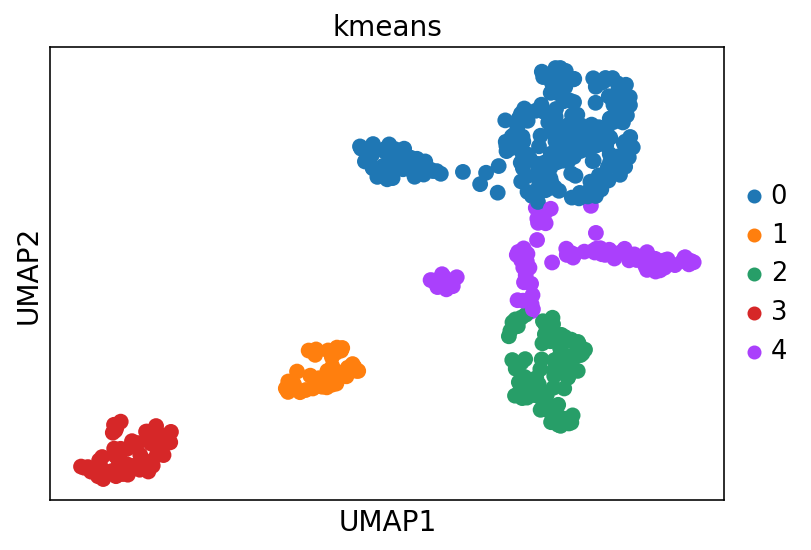

In [143]:
# Recalculating with 5 clusters
cerebellum = adata[adata.obs['subtissue'] == 'Cerebellum']
sc.pp.neighbors(cerebellum)
sc.tl.umap(cerebellum)

umap_coordinates = cerebellum.obsm['X_umap'] 
kmeans = KMeans(n_clusters=5, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

cerebellum.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
cerebellum.obs['kmeans'] = cerebellum.obs['kmeans'].astype(str)

sc.pl.umap(cerebellum, color='kmeans') # plot the results

In [148]:
sc.tl.leiden(adata, resolution=0.1)
#help(sc.tl.louvain)
adata.write(path + 'brain_clusters.h5ad')

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


# Differential expression & cluster annotation

Now that we've assigned cells into clusters, we'd like to understand what makes each cluster different from other cells in the dataset, or to annotate clusters according to their cell types (as has been previously done for this dataset).

There are several approaches to this task:

Look for upregulation of marker genes for cell types of interest (compared to the rest of the dataset)
Compare the complete gene expression profiles between groups
Use automated methods to compare cells of interest to databases of cell type expression profiles to combine clustering and annotation
Automated methods are a promising advance, but are not yet able to replace careful human curation.

For well-defined cell types, we expect marker genes to show large differences in expression between the cell type of interest and the rest of the dataset, allowing us to use simple methods. We'll focus on this approach for this workshop, while building intuition that is broadly applicable to other approaches.


For differential expression, we need to use the raw values stored in adata.raw. 
With differential expression, we want to account for both the center and spread of the expression in each group. Recall that when we normalized our values, we standardized the distribution of each gene across cells to be centered at 0 and scaled with variance 1. So, when calculating differential expression, we should use the raw values (post-QC, pre-normalization). We saved these in adata.raw earlier on.

In [6]:
adata = sc.read(path + 'brain_clusters.h5ad')
raw = pd.DataFrame(data=adata.raw.X, index=adata.raw.obs_names, columns=adata.raw.var_names)

## Comparing distributions 

Differential expression algorithms represent various approaches to comparing the distribution of gene expression in one group versus another group. Unlike bulk RNA-seq, we generally have a large number of samples (i.e. cells) for each group we are comparing in single-cell experiments. Thus, we can take advantage of the whole distribution of expression values in each group to identify differences between groups rather than only comparing estimates of mean-expression as is standard for bulk RNASeq.

In [152]:
astrocyte_marker = 'Gja1' # define genes of interest
# housekeeping = 'Chmp2a' 

cluster2 = raw[adata.obs['leiden'] == '2'] # Use a mask to subset dataset to cells assigned to cluster 2
not_cluster2 = raw[adata.obs['leiden'] != '2'] # All other cells

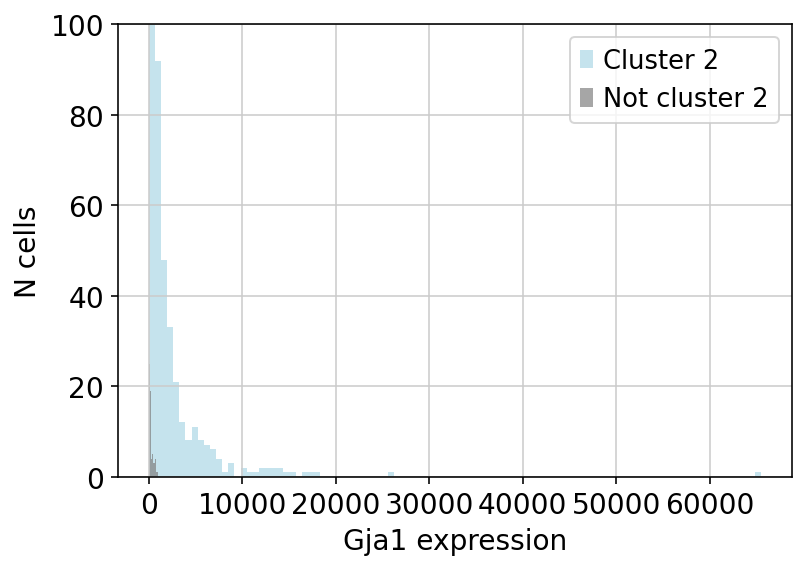

In [154]:
cluster2_marker_exp = cluster2[astrocyte_marker] 
plt.hist(cluster2_marker_exp.values, bins=100, color='lightblue', alpha=0.7, label='Cluster 2') # Plot distribution

not_cluster2_marker_exp = not_cluster2[astrocyte_marker]
plt.hist(not_cluster2_marker_exp, bins=100, color='gray', alpha=0.7, label='Not cluster 2')

plt.ylim(0,100) # Cut off at N=100 for visual clarity
plt.xlabel('%s expression'%astrocyte_marker) # label our axes
plt.ylabel('N cells')
plt.legend()

We can see that cells in Cluster 2 have higher rates of Gja1 expression that those not in the cluster, though there is overlap.

We can test if this is due to chance by hypothesis testing and checking the p-value.

In [7]:


ttest = ttest_ind(cluster2_marker_exp, 
          not_cluster2_marker_exp, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
print(ttest)

NameError: name 'cluster2_marker_exp' is not defined

The p-value is extremely low, which shows that we can  reject the null hypothesis.  The expressions levels of Gja1 between cells outside and inside of Cluster 2 are likely not due to chance, and this sample suggests they have true differences in mean expression.

A t-test is useful since it compares the data to the null hypothesis that the means of two distributions are equivalent. This accounts for the mean, standard deviation, and sample size of the two distributions. However, a p-value alone does not tell us anything about the *magnitude* of that difference: with large N, even very small (and biologically meaningless) differences in expression values can still return very "statistically significant" p-values.

We also cannot say that this definitely shows that Cluster 2 is capturing the astrocyte cells.  Although many cells in this cluster express the marker gene, there are many that don't. We should be careful before assuming that a cluster == a cell type.

In [12]:
sero_gene = 'Htr2a'
dopa_gene = 'Drd1a'
#ht_genes = [i for i in cluster2.columns if 'ht' in i.lower()]
#d1_genes = [i for i in cluster2.columns if 'drd' in i.lower()]
#print(d1_genes)

In [183]:
neurons = raw[ adata.obs['cell_ontology_class'] == 'neuron']
neurons

0610005C13Rik  0610007C21Rik  0610007L01Rik  \
cell                                                                    
A1.MAA000940.3_8_M.1.1              0.0           16.0            0.0   
A11.MAA000564.3_10_M.1.1            0.0            0.0           43.0   
A11.MAA000942.3_8_M.1.1             0.0           73.0            0.0   
A12.MAA000615.3_10_M.1.1            0.0          592.0          109.0   
A13.MAA000424.3_11_M.1.1            0.0           43.0            0.0   
...                                 ...            ...            ...   
P3.MAA000940.3_8_M.1.1              0.0           42.0            0.0   
P5.MAA000940.3_8_M.1.1              0.0            0.0            7.0   
P7.B000404.3_56_F.1.1               0.0            0.0            0.0   
P7.MAA000925.3_9_M.1.1              0.0           44.0           32.0   
P8.B000404.3_56_F.1.1               0.0          124.0            0.0   

                          0610007N19Rik  0610007P08Rik  0610007P14Rik  \
cell                                                                    
A1.MAA000940.3_8_M.1.1              0.0            2.0            1.0   
A11.MAA000564.3_10_M.1.1            0.0            0.0           98.0   
A11.MAA000942.3_8_M.1.1             0.0            0.0           41.0   
A12.MAA000615.3_10_M.1.1            0.0          200.0          146.0   
A13.MAA000424.3_11_M.1.1            0.0            0.0          368.0   
...                                 ...            ...            ...   
P3.MAA000940.3_8_M.1.1              0.0            0.0           28.0   
P5.MAA000940.3_8_M.1.1              0.0            0.0            3.0   
P7.B000404.3_56_F.1.1               0.0            0.0           60.0   
P7.MAA000925.3_9_M.1.1              0.0            0.0            1.0   
P8.B000404.3_56_F.1.1               0.0            0.0          237.0   

                          0610007P22Rik  0610009B14Rik  0610009B22Rik  \
cell                                                                    
A1.MAA000940.3_8_M.1.1              0.0            0.0            8.0   
A11.MAA000564.3_10_M.1.1            0.0            0.0           53.0   
A11.MAA000942.3_8_M.1.1            66.0            0.0           18.0   
A12.MAA000615.3_10_M.1.1            0.0            0.0            0.0   
A13.MAA000424.3_11_M.1.1            0.0            0.0           76.0   
...                                 ...            ...            ...   
P3.MAA000940.3_8_M.1.1              2.0            0.0           13.0   
P5.MAA000940.3_8_M.1.1              0.0            0.0            4.0   
P7.B000404.3_56_F.1.1               0.0            0.0            0.0   
P7.MAA000925.3_9_M.1.1            127.0            0.0            0.0   
P8.B000404.3_56_F.1.1               0.0            0.0            0.0   

                          0610009D07Rik  ...   Zwint  Zxda  Zxdb   Zxdc  \
cell                                     ...                              
A1.MAA000940.3_8_M.1.1             27.0  ...   111.0   0.0   0.0    6.0   
A11.MAA000564.3_10_M.1.1           40.0  ...   510.0   1.0   0.0    0.0   
A11.MAA000942.3_8_M.1.1            40.0  ...   238.0   0.0   0.0    0.0   
A12.MAA000615.3_10_M.1.1          137.0  ...  1950.0   0.0   0.0    0.0   
A13.MAA000424.3_11_M.1.1           41.0  ...  1481.0   0.0   0.0  143.0   
...                                 ...  ...     ...   ...   ...    ...   
P3.MAA000940.3_8_M.1.1              0.0  ...    13.0   0.0   0.0    0.0   
P5.MAA000940.3_8_M.1.1              2.0  ...    28.0   0.0   0.0    0.0   
P7.B000404.3_56_F.1.1               0.0  ...   402.0   0.0   0.0  371.0   
P7.MAA000925.3_9_M.1.1             63.0  ...   533.0   3.0   0.0   26.0   
P8.B000404.3_56_F.1.1             125.0  ...  1813.0   0.0   0.0    0.0   

                          Zyg11b    Zyx  Zzef1   Zzz3    a  l7Rn6  
cell                                                               
A1.MAA000940.3_8_M.1.1       3.0    0.0    0.0    0.0  0.0   13.

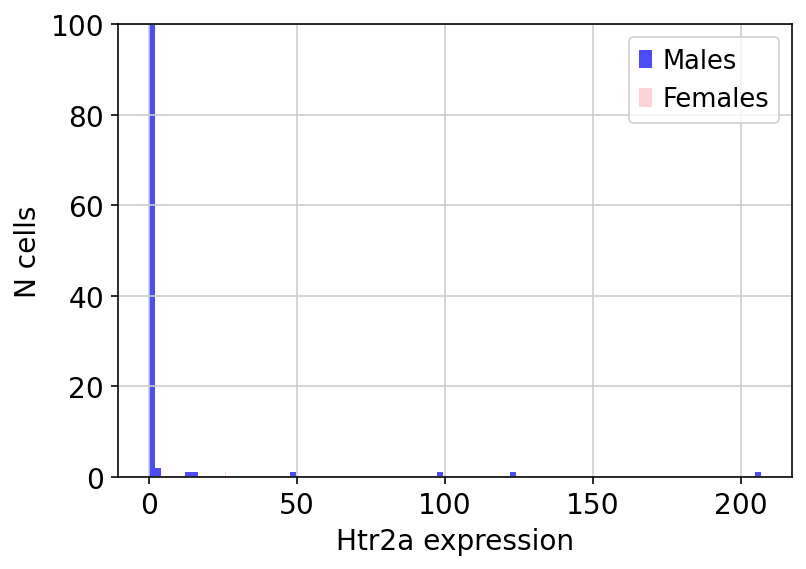

In [189]:


males   = raw[ (adata.obs['cell_ontology_class'] == 'neuron') & (adata.obs['mouse.sex'] == 'M')]
females   = raw[ (adata.obs['cell_ontology_class'] == 'neuron') & (adata.obs['mouse.sex'] == 'F')]

males_sero = males[sero_gene] 
plt.hist(males_sero.values, bins=100, color='blue', alpha=0.7, label='Males') # Plot distribution

females_sero = females[sero_gene]
plt.hist(females_sero, bins=100, color='pink', alpha=0.7, label='Females')

plt.ylim(0,100) # Cut off at N=100 for visual clarity
plt.xlabel('%s expression'%sero_gene) # label our axes
plt.ylabel('N cells')
plt.legend()

In [190]:


ttest = ttest_ind(males_sero, 
          females_sero, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
print(ttest)

Ttest_indResult(statistic=1.0512627296969472, pvalue=0.2943855075794675)


No significant difference between male and female neurons in the expression of Htr2a

Ttest_indResult(statistic=1.5156573593571818, pvalue=0.1306562192723857)


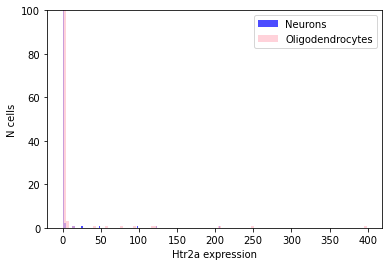

In [15]:
neurons = raw[ (adata.obs['cell_ontology_class'] == 'neuron') ]
non_neurons = raw[ (adata.obs['cell_ontology_class'] != 'neuron') ]

neurons_sero = neurons[sero_gene] 
plt.hist(neurons_sero.values, bins=100, color='blue', alpha=0.7, label='Neurons') # Plot distribution

non_neurons_sero = non_neurons[sero_gene]
plt.hist(non_neurons_sero, bins=100, color='pink', alpha=0.7, label='Non-neurons')

plt.ylim(0,100) # Cut off at N=100 for visual clarity
plt.xlabel('%s expression'%sero_gene) # label our axes
plt.ylabel('N cells')
plt.legend()

ttest = ttest_ind(neurons_sero, 
          non_neurons_sero, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
print(ttest)

In [9]:
neurons = raw[ (adata.obs['cell_ontology_class'] == 'neuron') ]
non_neurons = raw[ (adata.obs['cell_ontology_class'] != 'neuron') ]

neurons_dopa= neurons[dopa_gene] 
plt.hist(neurons_dopa.values, bins=100, color='blue', alpha=0.7, label='Neurons') # Plot distribution

non_neurons_sero = non_neurons[dopa_gene]
plt.hist(non_neurons_sero, bins=100, color='pink', alpha=0.7, label='Non-neurons')

plt.ylim(0,100) # Cut off at N=100 for visual clarity
plt.xlabel('%s expression'%sero_gene) # label our axes
plt.ylabel('N cells')
plt.legend()

ttest = ttest_ind(neurons_sero, 
          non_neurons_sero, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
print(ttest)

['astrocyte', 'oligodendrocyte', 'endothelial cell', 'neuron', 'oligodendrocyte precursor cell', 'Bergmann glial cell', 'brain pericyte']
Categories (7, object): ['Bergmann glial cell', 'astrocyte', 'brain pericyte', 'endothelial cell', 'neuron', 'oligodendrocyte', 'oligodendrocyte precursor cell']

In [44]:
def DiffExprCellGene(adata, cellType, gene):
    cells     = raw[ (adata.obs['cell_ontology_class'] == cellType) ]
    non_cells = raw[ (adata.obs['cell_ontology_class'] != cellType) ]
    
    cells_gene     = cells[gene]
    non_cells_gene = non_cells[gene]
    
    non_cellType = 'non-' + cellType
    
    plt.hist(cells_gene.values, bins=100, color='red', alpha=0.7, label=cellType) 
    plt.hist(non_cells_gene.values, bins=100, color='blue', alpha=0.7, label=non_cellType) 
    
    plt.ylim(0,100) # Cut off at N=100 for visual clarity
    plt.xlabel('%s expression'%gene) # label our axes
    plt.ylabel('N cells')
    plt.legend()
    
    ttest = ttest_ind(cells_gene, 
          non_cells_gene, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
    print(ttest)

In [53]:
def DiffTTestCellGene(adata, cellType, gene):
    cells     = raw[ (adata.obs['cell_ontology_class'] == cellType) ]
    non_cells = raw[ (adata.obs['cell_ontology_class'] != cellType) ]
    
    cells_gene     = cells[gene]
    non_cells_gene = non_cells[gene]
    
    non_cellType = 'non-' + cellType
    
    ttest = ttest_ind(cells_gene, 
          non_cells_gene, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
    #print(cellType, gene, ttest)
    return ttest

Ttest_indResult(statistic=5.1620437133103225, pvalue=4.6534071778137637e-07)


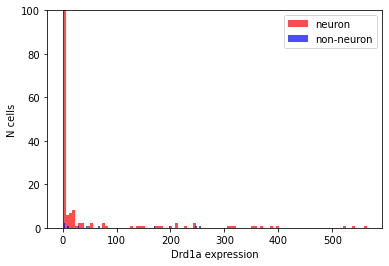

In [20]:
# Significant difference in dopamine receptor expression in neurons
DiffExprCellGene(adata, 'neuron', 'Drd1a')

In [21]:
cell_types = pd.unique(adata.obs['cell_ontology_class'].values)
cell_types

['astrocyte', 'oligodendrocyte', 'endothelial cell', 'neuron', 'oligodendrocyte precursor cell', 'Bergmann glial cell', 'brain pericyte']
Categories (7, object): ['Bergmann glial cell', 'astrocyte', 'brain pericyte', 'endothelial cell', 'neuron', 'oligodendrocyte', 'oligodendrocyte precursor cell']

Ttest_indResult(statistic=-5.479367865313947, pvalue=4.64797961888206e-08)


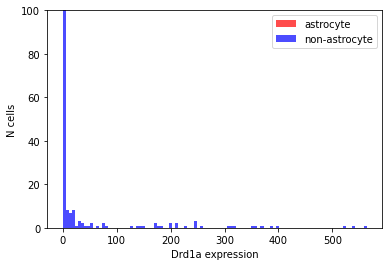

In [22]:
# Significant difference in dopamine receptor expression in astrocytes
DiffExprCellGene(adata, 'astrocyte', 'Drd1a')

Ttest_indResult(statistic=1.2941596599159615, pvalue=0.19741835971860275)


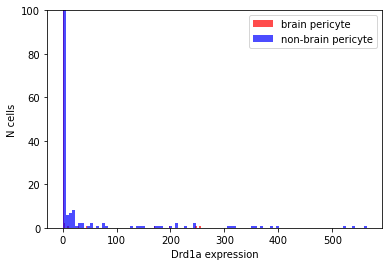

In [24]:
# No significant difference in dopamine receptor expression 
DiffExprCellGene(adata, 'brain pericyte', 'Drd1a')

In [58]:
ht_genes = [i for i in adata.var.index if ('htr' in i.lower() and i.lower()[0] == 'h')]
d1_genes = [i for i in adata.var.index if ('drd' in i.lower() and i.lower()[0] == 'd')]
#d1_genes = [i for i in cluster2.columns if 'drd' in i.lower()]
#print(ht_genes)

In [56]:
notsignificant = 0
significant = 0
for gene in ht_genes:
    for cellType in cell_types:
        #print(cellType, gene)
        ttest = DiffTTestCellGene(adata, cellType, gene)
        if ttest.pvalue < 0.01:
            print(cellType, gene, ttest.pvalue)
            significant += 1
        else:
            notsignificant += 1
        #help(ttest)
        #print(ttest.pvalue)
        
    
    #cell
print(notsignificant, significant)

astrocyte Htr1b 2.263576471297013e-05
oligodendrocyte Htr1b 2.2307815295356697e-05
endothelial cell Htr1b 2.4974349019802715e-05
neuron Htr1b 0.0033731022528239625
Bergmann glial cell Htr1b 2.2703042303648183e-05
brain pericyte Htr1b 0.004854247316148856
astrocyte Htr1d 0.005600613811557195
oligodendrocyte Htr1d 0.005589131590175906
endothelial cell Htr1d 0.007275064290933984
neuron Htr1d 0.005753637952551382
oligodendrocyte precursor cell Htr1d 0.005601978767101553
Bergmann glial cell Htr1d 0.005602958164433864
brain pericyte Htr1d 0.005602265894539392
astrocyte Htr2a 0.001737220663731544
oligodendrocyte Htr2a 0.0016978871566114032
oligodendrocyte precursor cell Htr2a 0.0016635530609442344
Bergmann glial cell Htr2a 0.0016640938811373768
brain pericyte Htr2a 0.0018720934278199156
Bergmann glial cell Htr2b 0.00888497584398796
astrocyte Htr2c 0.0009214882707447705
oligodendrocyte Htr2c 0.0009170006417785002
endothelial cell Htr2c 0.0009753848140141504
neuron Htr2c 0.0008882659326585446
o

In [59]:
notsignificant = 0
significant = 0
for gene in d1_genes:
    for cellType in cell_types:
        #print(cellType, gene)
        ttest = DiffTTestCellGene(adata, cellType, gene)
        if ttest.pvalue < 0.01:
            print(cellType, gene, ttest.pvalue)
            significant += 1
        else:
            notsignificant += 1
        #help(ttest)
        #print(ttest.pvalue)
        
    
    #cell
print(notsignificant, significant)

astrocyte Drd1a 4.64797961888206e-08
oligodendrocyte Drd1a 4.4880138015404095e-08
endothelial cell Drd1a 1.8629857414178205e-07
neuron Drd1a 4.6534071778137637e-07
oligodendrocyte precursor cell Drd1a 4.671652784140621e-08
Bergmann glial cell Drd1a 4.6886359305468714e-08
astrocyte Drd2 9.712934803601706e-05
oligodendrocyte Drd2 0.0067877554365715605
endothelial cell Drd2 0.0001525723804593421
neuron Drd2 0.0004874099724295884
oligodendrocyte precursor cell Drd2 5.490090718536606e-05
Bergmann glial cell Drd2 5.19289363964094e-05
brain pericyte Drd2 0.0001495375543425222
22 13


In [76]:
def DiffTTestCellGeneMF(adata, cellType, gene):
    males   = raw[(adata.obs['cell_ontology_class'] == cellType) & (adata.obs['mouse.sex'] == 'M')]
    females = raw[(adata.obs['cell_ontology_class'] == cellType) & (adata.obs['mouse.sex'] == 'F')]
    
    males_gene    = males[gene]
    females_gene  = females[gene]
    
    #non_cellType = 'non-' + cellType
    
    ttest = ttest_ind(males_gene, 
          females_gene, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
    #print(cellType, gene, ttest)
    return ttest
    

In [86]:
dopa = [i for i in adata.var.index if ('slc18' in i.lower())]
dopa

['Slc18a1', 'Slc18a2', 'Slc18a3']

In [87]:
sero_genes = ['Tph1','Tph2', 'Htt']
dopa_genes = ['Slc6a3','Slc18a2']

In [98]:
notsignificant = 0
significant = 0
for gene in sero_genes:
    for cellType in cell_types:
        #print(cellType, gene)
        ttest = DiffTTestCellGeneMF(adata, cellType, gene)
        if ttest.pvalue < 0.01:
            print(cellType, gene, ttest.pvalue)
            significant += 1
        else:
            notsignificant += 1
        #help(ttest)
        #print(ttest.pvalue)
        
    
    #cell
print(notsignificant, significant)

oligodendrocyte Htt 0.00026883172235517906
20 1


In [92]:

significant_differences = {}
for cellType in cell_types:
    notsignificant = 0
    significant = 0
    significant_differences[cellType] = []
    for gene in adata.var.index:
        #print(cellType, gene)
        ttest = DiffTTestCellGeneMF(adata, cellType, gene)
        if ttest.pvalue < 0.01:
            print(cellType, gene, ttest.pvalue)
            significant_differences[cellType].append((gene, ttest.pvalue))
            significant += 1
        else:
            notsignificant += 1
        #help(ttest)
        #print(ttest.pvalue)
    print(cellType, notsignificant, significant)
        
    
    #cell
print(notsignificant, significant)
        

astrocyte 0610040J01Rik 0.0012116063359450088
astrocyte 1110018J18Rik 0.00183057681548492
astrocyte 1110020G09Rik 6.066130237223431e-05
astrocyte 1110028C15Rik 0.003170097583496864
astrocyte 1110046J04Rik 0.009763935277971312
astrocyte 1190002N15Rik 0.007049865538760027
astrocyte 1200014J11Rik 0.0023737816024291753
astrocyte 1300010F03Rik 0.007822679954691752
astrocyte 1500002O20Rik 0.005966649537922298
astrocyte 1700003M07Rik 0.008782436095630333
astrocyte 1700008J07Rik 0.0063672880869772895
astrocyte 1700034P13Rik 0.008454572793454018
astrocyte 1810063B07Rik 0.001978266841149907
astrocyte 1810065E05Rik 0.0004237793865364595
astrocyte 2010106G01Rik 2.9225398180042684e-06
astrocyte 2210415F13Rik 0.0011997941573882872
astrocyte 2310004N24Rik 0.00026000238677618216
astrocyte 2310011J03Rik 0.0009748044170713528
astrocyte 2310021P13Rik 0.009206230875486466
astrocyte 2410002O22Rik 0.008520080772448728
astrocyte 2610008E11Rik 0.008648748381631313
astrocyte 2610507I01Rik 0.0025860947316006418

In [97]:
for cell, diffs in significant_differences.items():
    print(cell, len(diffs), len(diffs)/total_genes)

astrocyte 982 0.05283831046542911
oligodendrocyte 1894 0.1019101425881087
endothelial cell 2055 0.11057304277643261
neuron 1435 0.07721280602636535
oligodendrocyte precursor cell 372 0.020016142050040354
Bergmann glial cell 491 0.026419155232714556
brain pericyte 2240 0.12052730696798493


In [95]:
total_genes = len(adata.var.index)